# Proyecto final: Elisa & Isabel

# **Bank Churn Prediction**

Antes de nada, importamos las librerías necesarias:

In [73]:
#generales

import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pickle import dump

#preprocesamiento y optimización
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

#modelización
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge

#métricas
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score

In [2]:
import warnings

warnings.filterwarnings("ignore")

### Planteamiento del problema y recopilación de datos

Con este Dataset descargado de Kaggle, queremos analizar el abandono bancario y, en sucesivas fases, poder entrenar un modelo de Machine Learning para responder a la pregunta: "¿Qué tipo de cliente tiene más probabilidad de abandonar/cambiar una entidad bancaria?". Por lo tanto, encontramos que el dataset del que disponemos puede ayudarnos a resolver la cuestión planteada y aplicamos un proceso de EDA para conocerlo con más en detalle.


Importaremos el conjunto de datos para comenzar a trabajar con él:

In [3]:
url="/workspaces/Isa-Project/data/friance new.csv"
data_raw=pd.read_csv(url)

#observamos que se hayan cargado correctamente los datos con las primeras 5 filas del dataset
data_raw.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,...,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


Vamos a echar un vistazo al número de datos, valores no nulos y tipo de datos de cada columna (lo utilizaremos posteriormente para el EDA)

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175028 entries, 0 to 175027
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Surname             175028 non-null  int64  
 1   CreditScore         175028 non-null  float64
 2   Age                 175028 non-null  float64
 3   Tenure              175028 non-null  float64
 4   Balance             175028 non-null  float64
 5   NumOfProducts       175028 non-null  float64
 6   HasCrCard           175028 non-null  int64  
 7   IsActiveMember      175028 non-null  int64  
 8   EstimatedSalary     175028 non-null  object 
 9   Exited              175028 non-null  int64  
 10  Surname_tfidf_0     175028 non-null  object 
 11  Surname_tfidf_1     175028 non-null  object 
 12  Surname_tfidf_2     175028 non-null  object 
 13  Surname_tfidf_3     175028 non-null  object 
 14  Surname_tfidf_4     175028 non-null  object 
 15  France              175028 non-nul

Duplicados y nulos: analizamos cuántos duplicados hay (y, de habérlos los eliminamos) y los nulos para tomar una decisión sobre ellos:

In [5]:
print(f"Duplicados: {data_raw.duplicated().sum()} Como existen duplicados, los eliminamos")
data_raw.drop_duplicates(inplace=True)
print(f"Comprobamos que ya no existen duplicados: {data_raw.duplicated().sum()}")

print(f"Nulos:\n{data_raw.isna().sum()} \n\nNo existen nulos en ninguna variable")

Duplicados: 41 Como existen duplicados, los eliminamos
Comprobamos que ya no existen duplicados: 0
Nulos:
Surname               0
CreditScore           0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Surname_tfidf_0       0
Surname_tfidf_1       0
Surname_tfidf_2       0
Surname_tfidf_3       0
Surname_tfidf_4       0
France                0
Germany               0
Spain                 0
Female                0
Male                  0
Mem__no__Products     0
Cred_Bal_Sal          0
Bal_sal               0
Tenure_Age            0
Age_Tenure_product    0
dtype: int64 

No existen nulos en ninguna variable


Vamos a realizar el EDA:

**Descripción de las variables:**

* **Surname** Apellido del cliente.- **Tipo**: int 

* **CreditScore** Puntuación de crédito, una medida de la solvencia crediticia. **Tipo**: float

* **Age** Edad del cliente. **Tipo**: float

* **Tenure** Número de años que el cliente ha sido cliente del banco. **Tipo**: float

* **Balance** Saldo de la cuenta del cliente. **Tipo**: float

* **NumOfProducts** Número de productos financieros que el cliente tiene con el banco. **Tipo**: float

* **IsActiveMember** Indica si el cliente es miembro activo de un servicio o producto; es una característica para predecir ciertos comportamientos del cliente, como la probabilidad de que un cliente cancele su membresía o realice ciertas transacciones. (1 si lo es, 0 si no). **Tipo**: int

* **HasCrCard** Indica si el cliente tiene una tarjeta de crédito (1 si tiene, 0 si no). **Tipo**: int

* **EstimatedSalary** Salario estimado del cliente. **Tipo**: object - ***transformar***

* **Surname_tfidf_0 a Surname_tfidf_4** Características de procesamiento de texto (TF-IDF) derivadas del apellido del cliente. **Tipo**: object

* **France, Germany, Spain**: Variables dummy que indican la nacionalidad del cliente. **Tipo**: int

* **Female, Male** Variables dummy que indican el género del cliente. **Tipo**: int

* **Exited** Variable objetivo, indica si el cliente ha abandonado el servicio (1, 0 no). **Tipo**: int


**Las siguientes variables, pueden representar la relación entre variables arriba descritas, debemos analizar bien esa relación (posteriormente en el EDA lo vemos):**

* **Mem__no__Products** Una característica derivada que puede representar la relación entre el número de productos y la membresía activa. **Tipo**: float

* **Cred_Bal_Sal** Una característica derivada que puede representar la relación entre el puntaje de crédito, el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Bal_sal** Una característica derivada que puede representar la relación entre el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Tenure_Age** Una característica derivada que puede representar la relación entre la antigüedad y la edad del cliente. **Tipo**: object - ***transformar***

* **Age_Tenure_product** Una característica derivada que puede representar la relación entre la edad, la antigüedad y el número de productos. **Tipo**: float


#### Eliminar información irrelevante

Cuando queremos preparar los datos para entrenar un modelo predictivo debemos responder a la siguiente pregunta: ¿son todas
las características imprescindibles para realizar una predicción? 

Normalmente, esa pregunta es un rotundo no. Tenemos que tratar de ser lo más objetivos posibles y llevar a cabo este proceso previo antes de la fase de selección de características. Por lo tanto,
aquí lo que trataremos de hacer es una eliminación controlada de aquellas variables que podemos prever que el algoritmo no va a utilizar en el proceso predictivo, o que no veamos que tengan mucha relevancia con respecto a la variable objetivo. 

En este caso, estas son las variables relacionadas con el apellido: 'Surname', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3' y 'Surname_tfidf_4' ya que nuestra variable objetivo es la baja del banco, en lo que el apellido no debe influir. 

Igualmente lo corroboramos con un gráfico poniendo de ejemplo la variable 'Surname'.

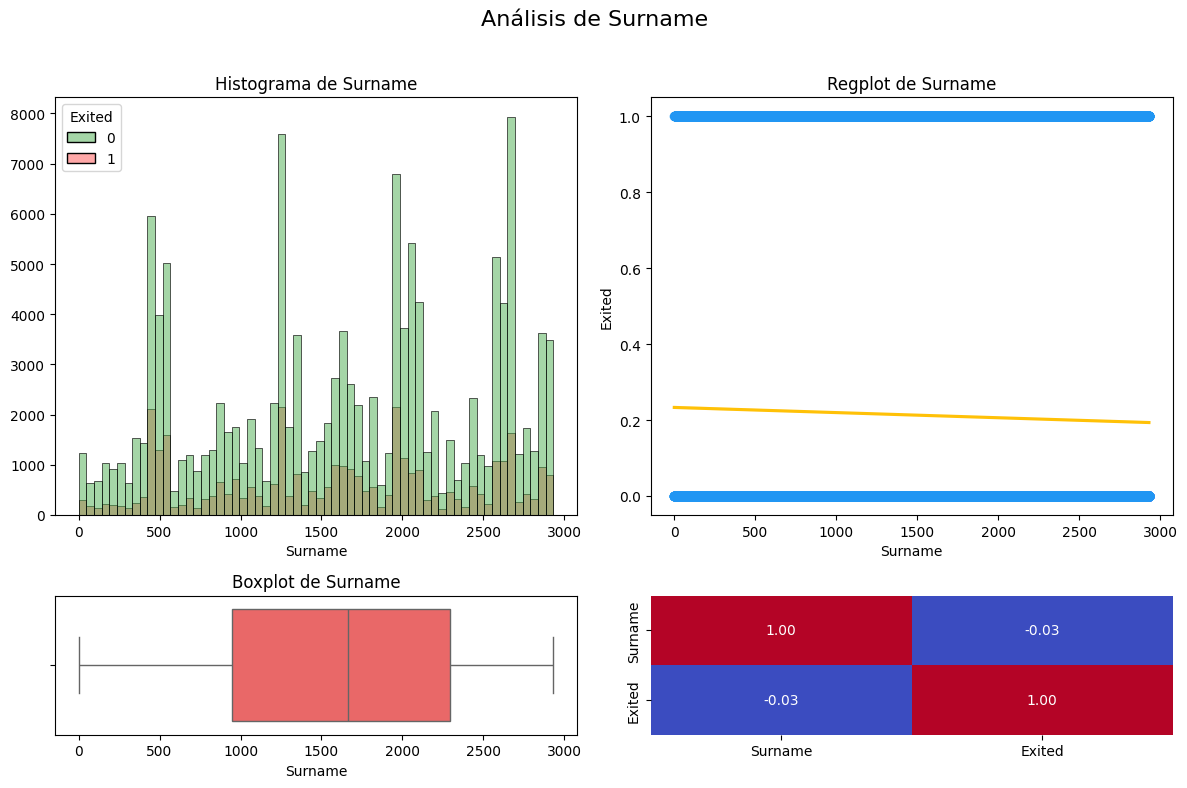

In [6]:
var = "Surname"
data_raw[var] = pd.to_numeric(data_raw[var], errors='coerce')
data_raw['Exited'] = pd.to_numeric(data_raw['Exited'], errors='coerce')

# Crear subgráficos
fig, axis = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

# Configurar el título principal
plt.suptitle(f"Análisis de {var}", fontsize=16)

# Histograma
sns.histplot(ax=axis[0, 0], data=data_raw, x=var, hue="Exited", palette=["#4CAF50", "#FF5252"]).set(ylabel=None)
axis[0, 0].set_title(f"Histograma de {var}")

# Regplot
sns.regplot(data=data_raw, x=var, y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
axis[0, 1].set_title(f"Regplot de {var}")

# Boxplot
sns.boxplot(ax=axis[1, 0], data=data_raw, x=var, palette=["#FF5252"])
axis[1, 0].set_title(f"Boxplot de {var}")

# Mapa de calor de correlación
sns.heatmap(data_raw[[var, "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")

# Ajustar diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostrar gráfico
plt.show()

Por tanto, eliminamos estas variables del dataset:

In [7]:
data_clean=data_raw.drop(['Surname', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4'], axis = 1, inplace = False)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


Vamos a analizar la **variable objetivo** *EXITED* por sí sola, para ver desbalanceos también

In [8]:
y=data_raw["Exited"]
print(y.describe())
print(pd.DataFrame({
    'Counts': y.value_counts(),
    'Proportion': y.value_counts() / len(y)
}))

count    174987.000000
mean          0.211176
std           0.408144
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Exited, dtype: float64
        Counts  Proportion
Exited                    
0       138034    0.788824
1        36953    0.211176


Tenemos suficientes "éxitos" (abandonos) 36953 (un 21,11%), hay que tener en cuenta estas estadísticas a la hora de coger la muestra de entrenamiento y test para validar que cumplan con las mismas proporciones.

Igualmente más adelante vamos a entrenar el modelo seleccionado con una muestra más balanceada de cara a ver si mejora las métricas.

De cara a reducir el dataset, vamos a agrupar las variables que se refieren al mismo tema:

* **Male/Female** en una sola: *Sex*
* **France/Germany/Spain** en *Countries*


In [9]:
data_clean["Sex"]=data_raw["Male"]

data_clean['Countries'] = data_raw['France'] * 1 + data_raw['Germany'] * 2 + data_raw['Spain'] * 3

# Mostrar el DataFrame resultante
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,...,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product,Sex,Countries
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,1,...,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0,1,1
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,1,...,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0,1,1
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,1,...,0,0,1,0.0,0.0,0.0,0.25,400.0,1,1
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1,...,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0,1,1
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,0,...,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0,1,3


Comprobamos las variables creadas:

[]

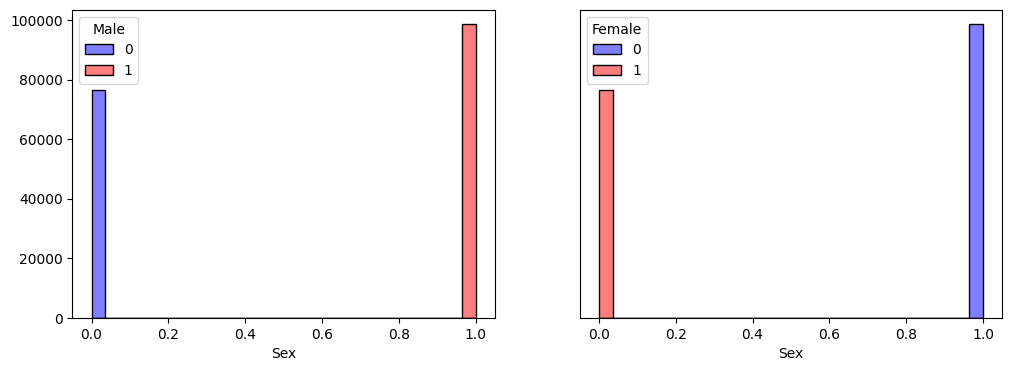

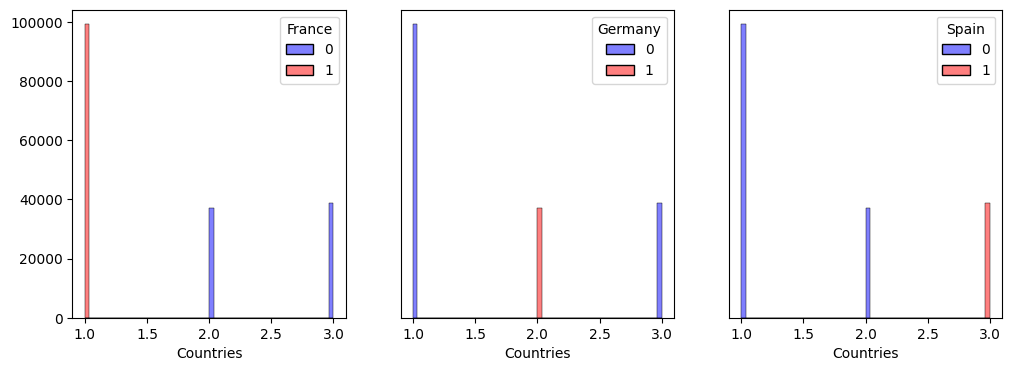

In [10]:
# Establecer la paleta de colores
sns.set_palette(["blue", "red"])

# Histograma para Male y Female
fig, axis= plt.subplots(1,2, figsize=(12,4))
sns.histplot(ax=axis[0], data = data_clean, x = "Sex",hue="Male").set(ylabel = None)
axis[1].set_yticks([])
sns.histplot(ax=axis[1], data = data_clean, x = "Sex",hue="Female").set(ylabel = None)

# Histograma para Countries ( France, Germany, Spain )
fig, axis= plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axis[0], data = data_clean, x = "Countries",hue="France").set(ylabel = None)
sns.histplot(ax=axis[1], data = data_clean, x = "Countries",hue="Germany").set(ylabel = None)
axis[2].set_yticks([])
sns.histplot(ax=axis[2], data = data_clean, x = "Countries",hue="Spain").set(ylabel = None)
axis[1].set_yticks([])

Están correctas las variables: 

* Sex=0 son las mujeres (Female) y Sex=1 son los hombres (Male)

* Countries=1 es France, Countries=2 es Germany y Countries=3 es Spain  


Mantenemos sólo Sex y Countries:

In [11]:
data_clean.drop(["Male","Female","Germany","Spain","France"],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product,Sex,Countries
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0,1,1
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0,1,1
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,0.0,0.0,0.25,400.0,1,1
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0,1,1
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0,1,3


Vamos a analizar las variables por separado primero (Age, Tenure, NumOfProducts, IsActiveMember, Sex), y después analizaremos las que parecen ser una combinación de otras (Tenure_Age,Age_Tenure_product,Mem__no__Products)

**Análisis variables independientes: Age, Tenure, NumOfProducts, IsActiveMember, Sex, CreditScore, Balance, Countries, EstimatedSalary, HasCrCard**

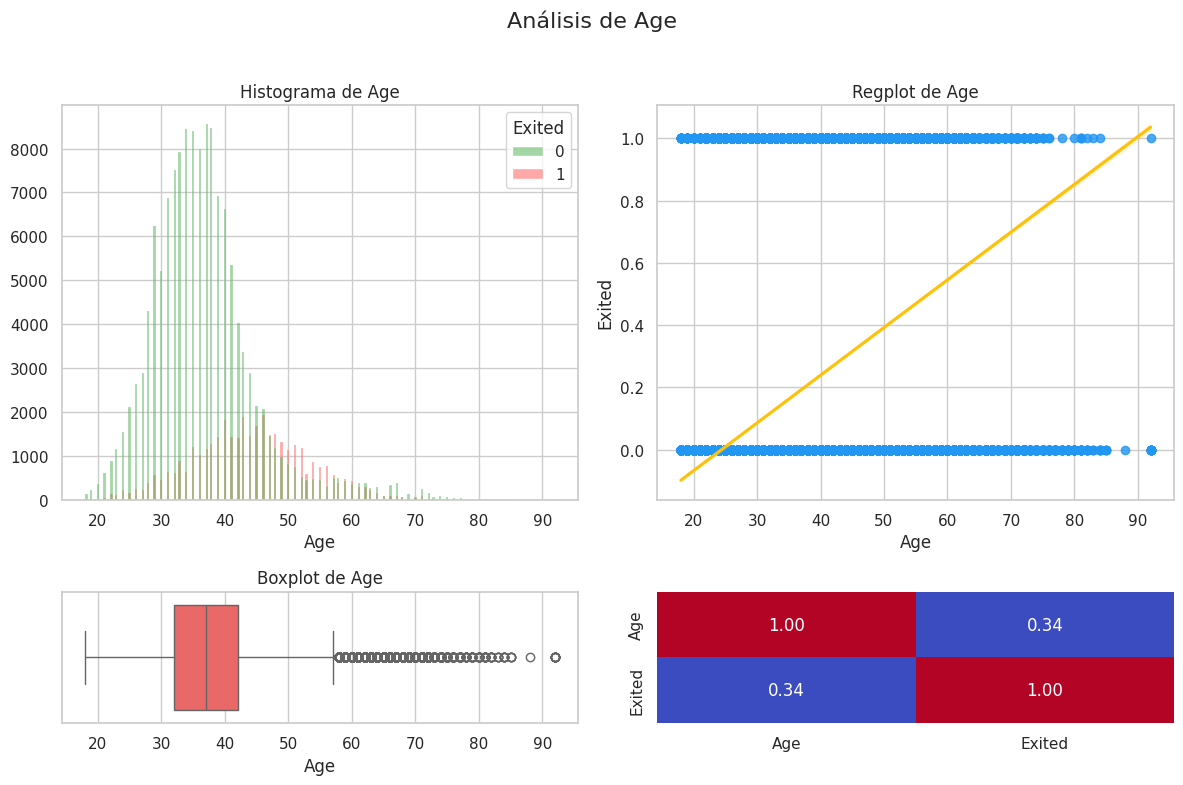

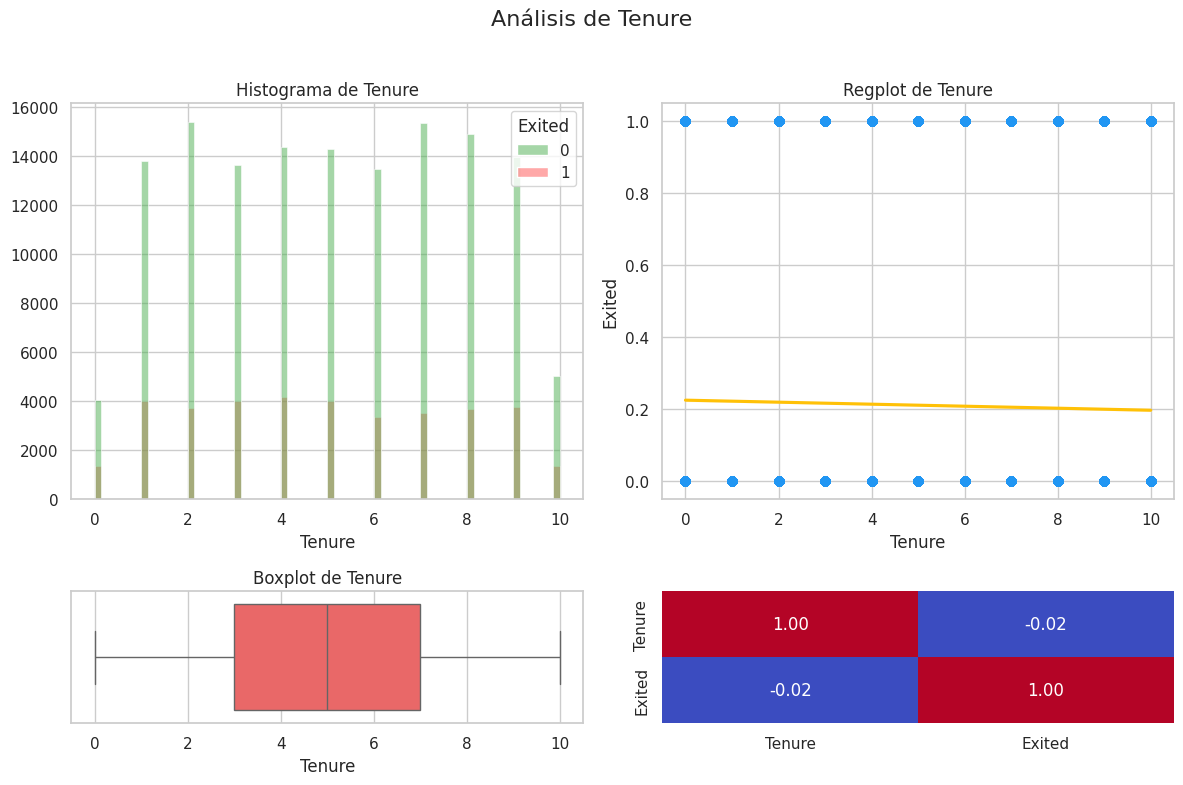

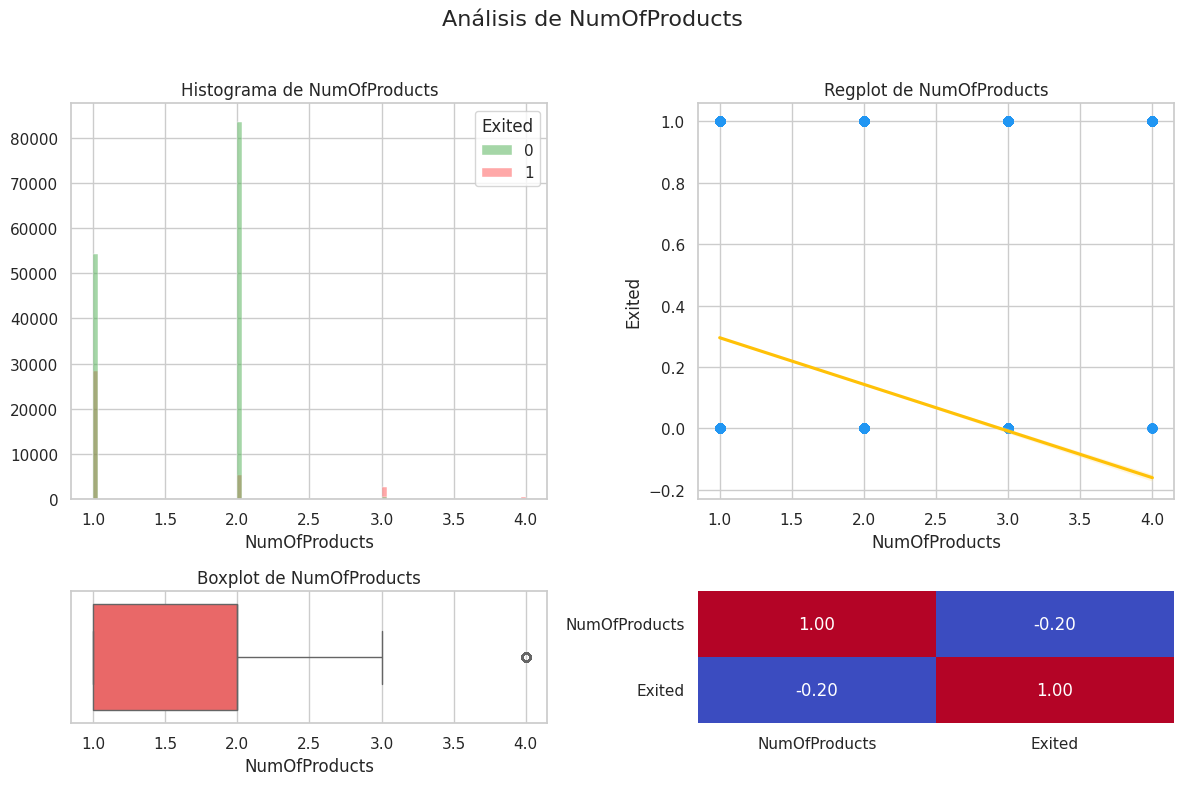

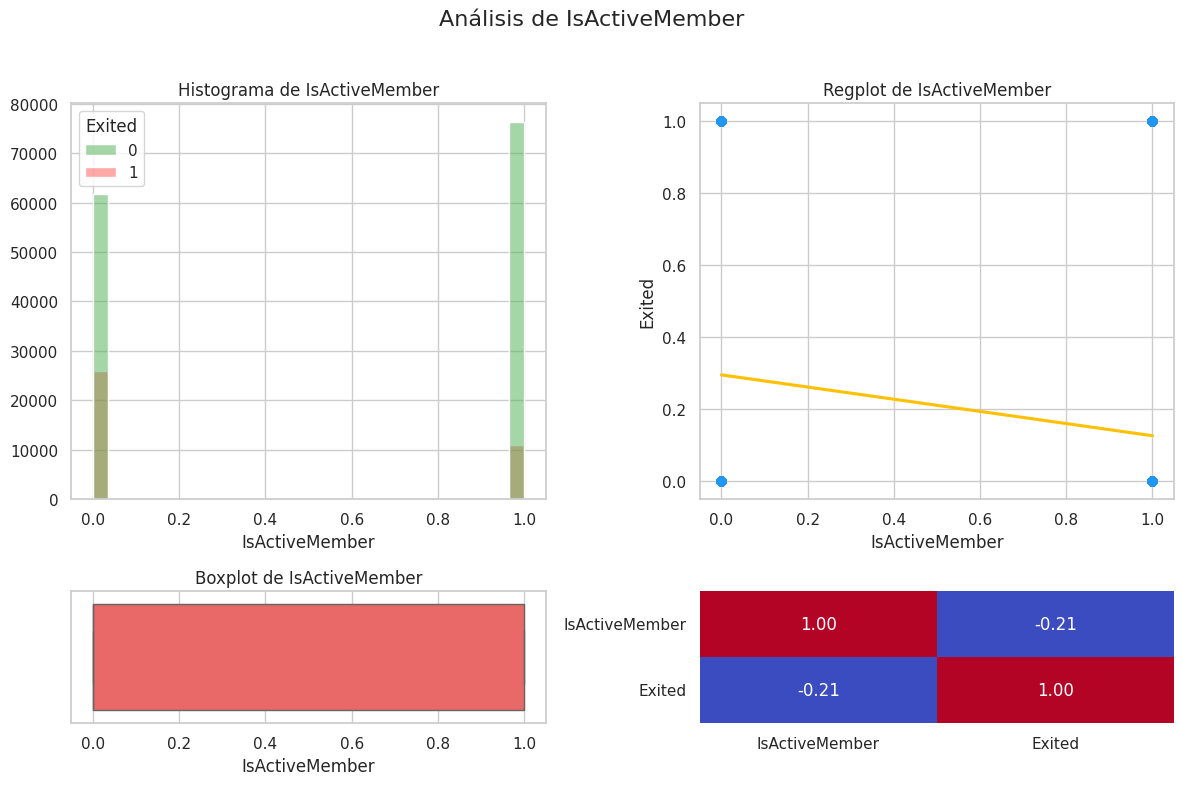

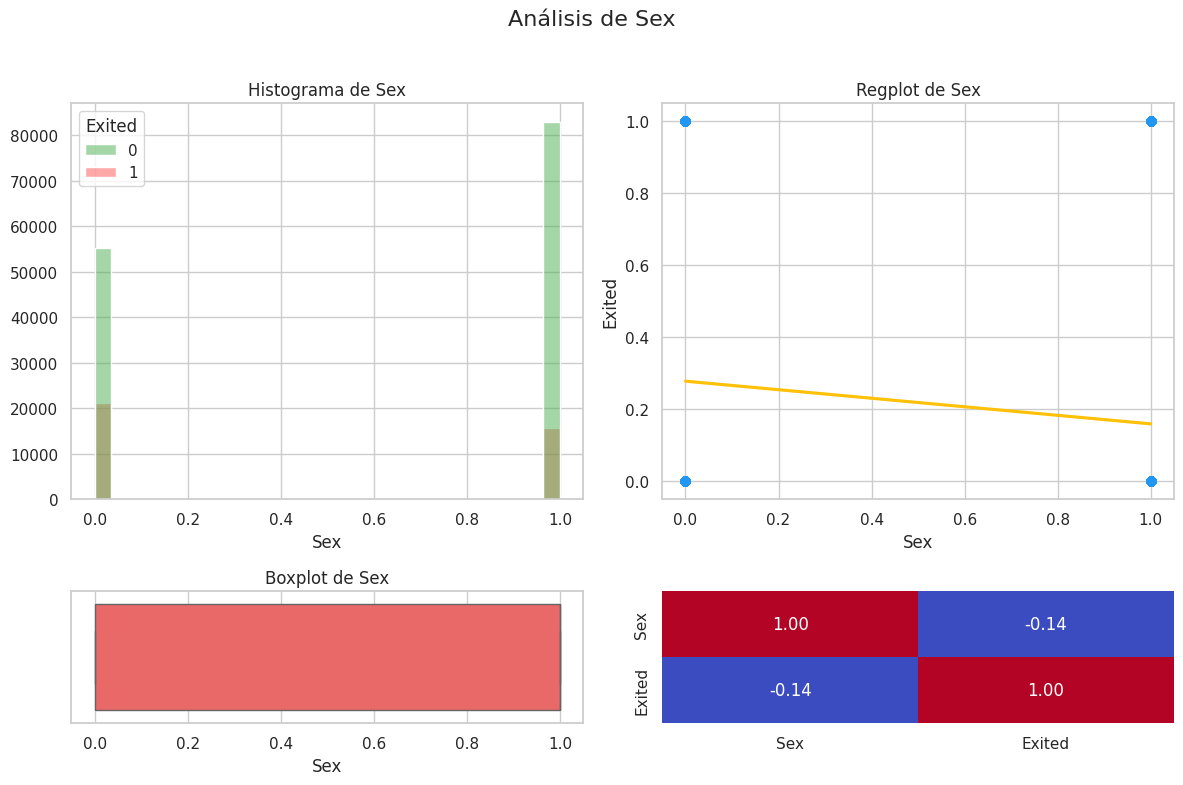

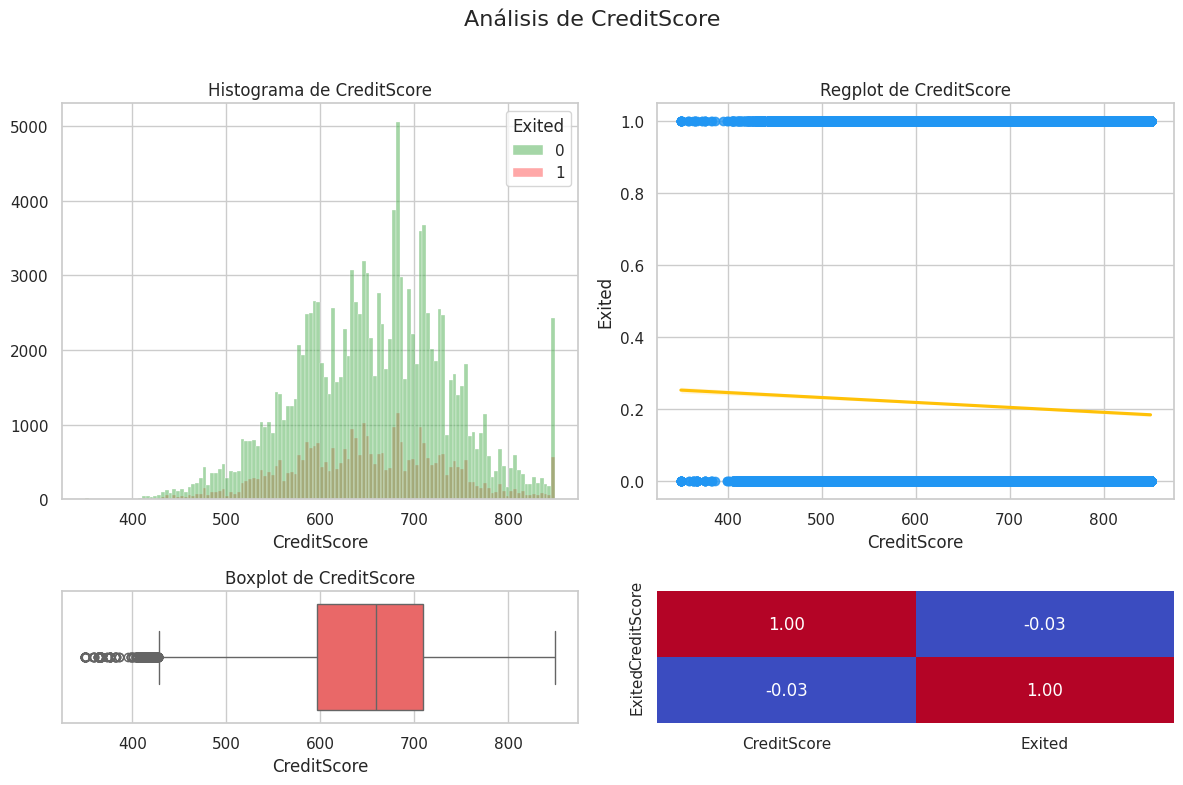

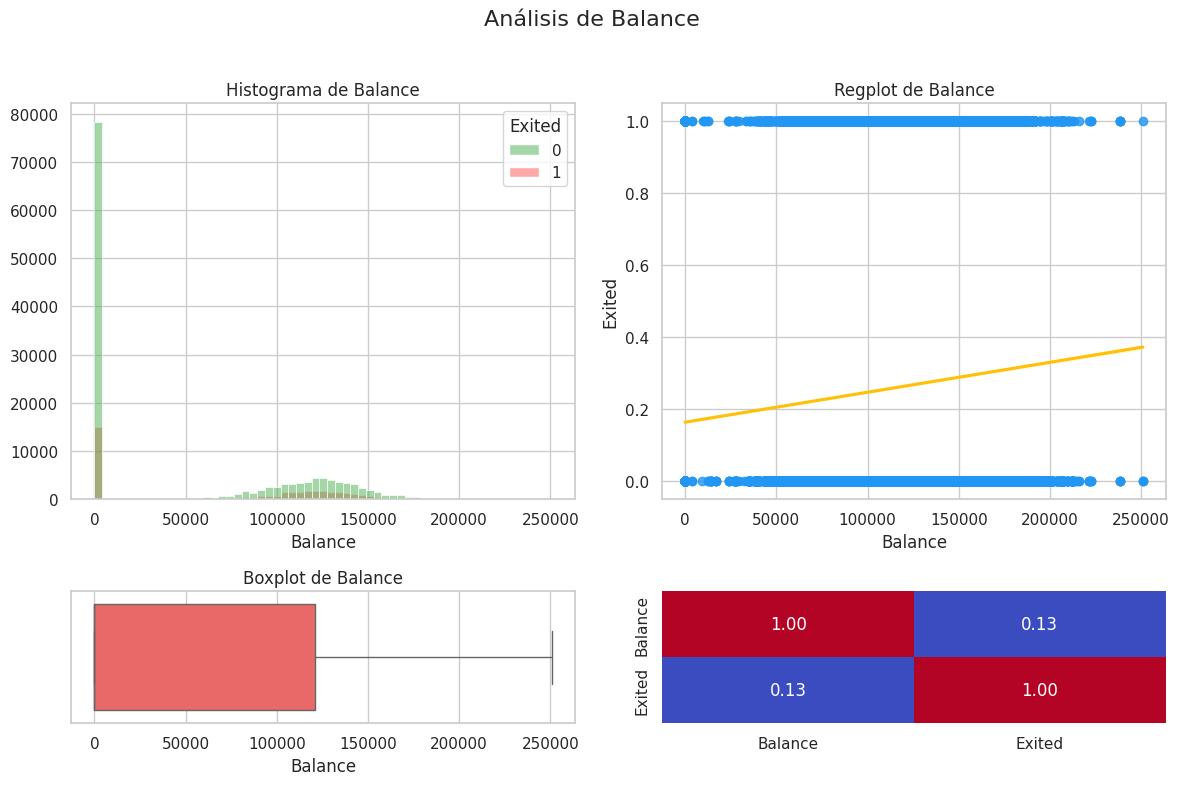

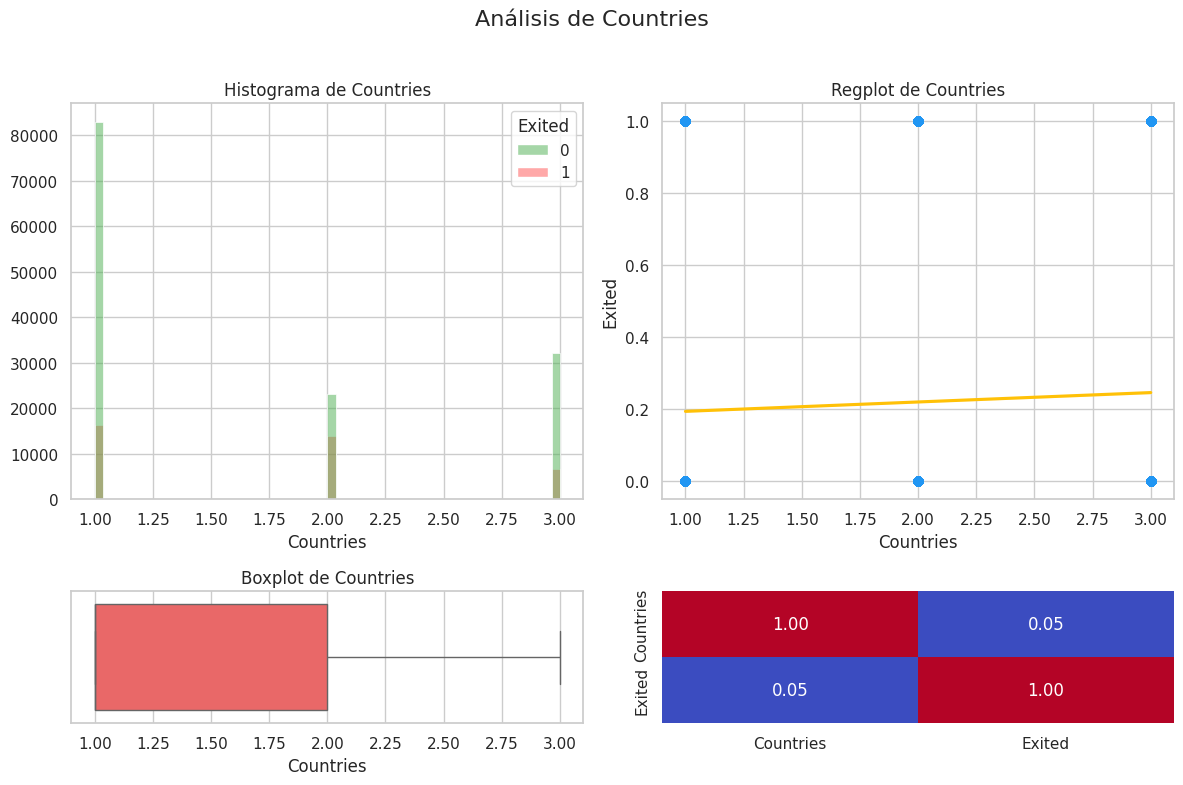

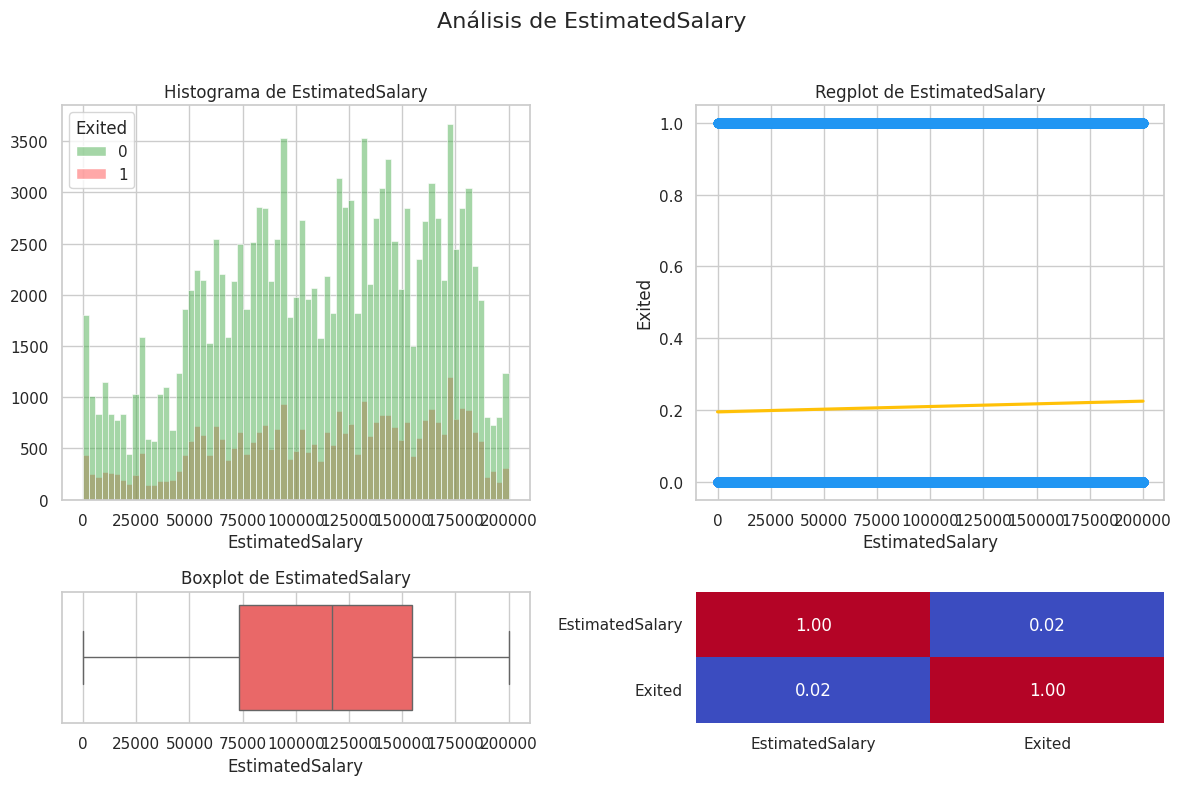

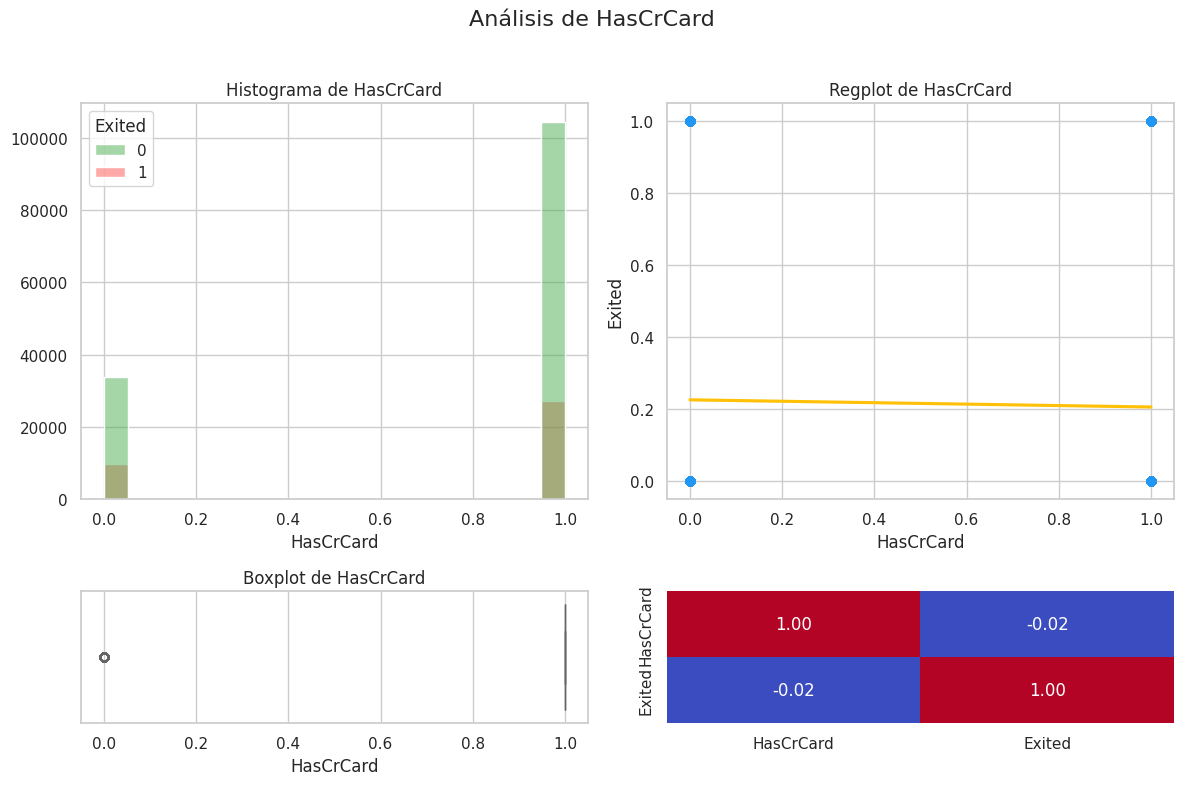

In [12]:
# HISTOGRAMAS, DIAGRAMA DE CAJAS Y MAPA DE CALOR DE CORRELACIÓN

sns.set_theme(style="whitegrid", palette="pastel")

vars = ["Age", "Tenure", "NumOfProducts", "IsActiveMember", "Sex","CreditScore","Balance","Countries","EstimatedSalary","HasCrCard"]

data_clean_=data_clean.apply(pd.to_numeric, errors='coerce')


for var in vars:
    # Crear subgráficos
    fig, axis = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Configurar el título principal
    plt.suptitle(f"Análisis de {var}", fontsize=16)

    # Histograma
    sns.histplot(ax=axis[0, 0], data=data_clean_, x=var, hue="Exited", palette=["#4CAF50", "#FF5252"]).set(ylabel=None)
    axis[0, 0].set_title(f"Histograma de {var}")

    # Regplot
    sns.regplot(data=data_clean_, x=var, y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
    axis[0, 1].set_title(f"Regplot de {var}")

    # Boxplot
    sns.boxplot(ax=axis[1, 0], data=data_clean_, x=var, palette=["#FF5252"])
    axis[1, 0].set_title(f"Boxplot de {var}")

    # Mapa de calor de correlación
    sns.heatmap(data_clean_[[var, "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")

    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Mostrar gráfico
    plt.show()

**ANALISIS DE LAS VARIABLES ARRIBA GRAFICADAS**

**AGE**

La variable edad concentra los atípicos en los valores altos de la variable  (por encima de los 60 años), sin embargo, podemos observar en el histograma, que en esos valores es donde se concentra el mayor porcentaje de abandonos (churn, nuestra variable objetivo *Exited*), lo que es corroborado también por la correlación positiva de 0.34 con la variable *Exited*. Por tanto, no vamos a tratar los outliers de la variable edad, y es una candidata a entrar en el modelo.

**TENURE**

La variable antigüedad, no contiene atípicos, es bastante uniforme y, además, vemos que no existe correlación ni visual (histograma) ni después en la correlación de -0.02. Esta variable es candidata a *NO* entrar en el modelo.

**NUMOFPRODUCTS**

La variable número de productos, vemos que tiene sólo 4 valores, de esos, más del 75% de los datos se concentran entre el valor 1 y 2, en la *Tabla1* vemos que el 3 concentra sólo el 1% de los datos y el 4 el 0,3%. Por tanto, no podemos tomar como significativos los % de abandono que aparecen en esos bloques. Sin embargo, sí que vemos en el histograma, que para el valor 1 el % de abandono es mucho mayor que para el valor 2. Esto también se comprueba con la correlación negativa -0.20. Esta variable es candidata a entrar en el modelo.

**ISACTIVEMEMBER**

La variable miembro activo, dicotómica, nos muestra que también tiene una correlación negativa con nuestra variable objetivo, siendo -0.21 la correlación, y visualmente podemos comprobar que el % de abandono es mayor en el valor 0 que en el 1 (miembro activo). Esta variable es candidata a entrar en el modelo.

**SEX**

La variable sexo, nos indica que, mientras que el banco tiene un mayor número de hombres (56%) (ver *Tabla2*), el % de abandono es mayor en las mujeres (28% vs 16%). Lo cual se comprueba con una correlación negativa (1 son hombres) con nuestra variable objetivo de -0.14. Esta variable es candidata a entrar en el modelo.
ANÁLISIS DE LAS VARIABLES ARRIBA GRAFICADAS

**CREDITSCORE**

Es una medida numérica que evalúa la solvencia crediticia de una persona. Representa la evaluación de la capacidad de un individuo para cumplir con las obligaciones crediticias. Cuanto mayor sea la puntuación, mayor será la solvencia crediticia. Al observar el diagrama de caja, encontramos muchos valores fuera del rango intercuartílico, sin embargo, estos valores estan dentro de un rango aceptable, como podemos ver en la *Tabla3*, la media y el percentil 0.01 no distan mucho, ni el máximo del mínimo, por tanto, no tiene mucho sentido tratarlos.

En este caso, una correlación del -0,03 indica que no hay una relación fuerte ni positiva ni negativa entre la puntuación de crédito (CreditScore) y la variable de abandono (Exited). Puede interpretarse como que, en términos lineales, la puntuación de crédito no tiene una influencia significativa en la probabilidad de que un cliente abandone el servicio.

**BALANCE**

Se refiere a la cantidad de dinero en una cuenta o la diferencia entre los ingresos y los gastos. En el contexto financiero, puede indicar el saldo de una cuenta bancaria, tarjeta de crédito o cualquier otro instrumento financiero. El 0.13 indica una correlación positiva débil. A medida que la variable Balance aumenta, hay una ligera tendencia a que también aumente la variable Exited, y viceversa. Es importante tener en cuenta que una correlación débil no implica causalidad. En otras palabras, la correlación no indica necesariamente que un mayor saldo (balance) cause que un cliente abandone o no el servicio.

**COUNTRIES**

En esta variables donde está definida los tres paises (Francia, Alemania y España) se puede observar que al comparar en el gráfico un 0.05 indica una correlación positiva extremadamente débil. No hay una relación fuerte entre la variable Countries y Exited, en términos de una relación lineal simple, tal y como hemos clasificado los países. Sin embargo, podemos ver que el % de abandono en Alemania es más del doble que en el resto de los países (ver *Tabla4* y *Grafico1*), por tanto, es una variable a tener en cuenta en el modelo.

**ESTIMATEDSALARY**

Representa la estimación del salario de una persona. El 0.02 indica una correlación positiva extremadamente débil. No hay una relación fuerte entre la variable EstimatedSalary y Exited. Esta baja correlación sugiere que la variable EstimatedSalary y la probabilidad de que un cliente abandone (variable Exited) no están fuertemente relacionadas linealmente. En términos simples, la variación en EstimatedSalary no predice de manera efectiva la variación en Exited de acuerdo con una relación lineal

**HASCRCARD**

Binaria que indica si tiene o no tarjeta de crédito. Observamos que no existe relación entre la tenencia de tarjeta de crédito y el abandono con una correlación de -0.02



Tabla 1: Comprobamos la distribución de la variable NumOfProducts

In [13]:
print(pd.DataFrame({
    'Counts': data_clean["NumOfProducts"].value_counts(),
    'Proportion': data_clean["NumOfProducts"].value_counts() / len(y)
}))

               Counts  Proportion
NumOfProducts                    
2.0             88853    0.507769
1.0             82440    0.471121
3.0              3159    0.018053
4.0               535    0.003057


Tabla2: Porcentaje Hombres-Mujeres frente a % Churn de cada sexo:

In [14]:
percentaje=(data_clean.groupby('Sex')['Exited'].count()/len(data_clean['Exited']))*100
churn=(data_clean.groupby("Sex")["Exited"].sum()/data_clean.groupby("Sex")["Exited"].count())*100

print(pd.DataFrame({
    'Sex':["Mujer","Hombre"],
    '%': round(percentaje,2) ,
    '% Churn': round(churn,2)
    
}))

        Sex      %  % Churn
Sex                        
0     Mujer  43.67    27.80
1    Hombre  56.33    15.94


Tabla3: Percentiles variable CreditScore

In [15]:
percentiles_CS = [0.01, 0.05,0.1]
additional_perc_CS = data_clean["CreditScore"].quantile(percentiles_CS)
# Combina los resultados de describe() con los percentiles adicionales
describe_with_perc_CS = data_clean["CreditScore"].describe()
describe_with_perc_CS.loc["1%"] = additional_perc_CS.loc[0.01]
describe_with_perc_CS.loc["5%"] = additional_perc_CS.loc[0.05]
describe_with_perc_CS.loc["10%"] = additional_perc_CS.loc[0.1]
describe_with_perc_CS

count    174987.000000
mean        656.115860
std          81.144293
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
1%          464.000000
5%          521.000000
10%         551.000000
Name: CreditScore, dtype: float64

Tabla4: Porcentaje por país frente a % Churn de cada país:

In [16]:

percentaje=(data_clean.groupby('Countries')['Exited'].count()/len(data_clean['Exited']))*100
churn=(data_clean.groupby("Countries")["Exited"].sum()/data_clean.groupby("Countries")["Exited"].count())*100

print(pd.DataFrame({
    'Countries':['France','Germany','Spain'],
    '%': round(percentaje,2) ,
    '% Churn': round(churn,2)
    
}))

          Countries      %  % Churn
Countries                          
1            France  56.69    16.51
2           Germany  21.21    37.53
3             Spain  22.10    17.19


Grafico1: Veámoslo gráficamente

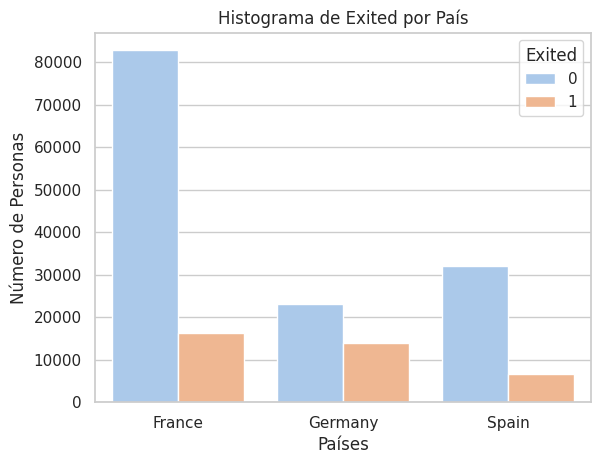

In [17]:

country_labels = {1: 'France', 2: 'Germany', 3: 'Spain'}

data_clean['Country_Labels'] = data_clean['Countries'].map(country_labels)

# Histograma de barras comparando 'Country_Labels' y 'Exited'
sns.countplot(data=data_clean.sort_values('Country_Labels'), x='Country_Labels', hue='Exited')

# Ajustar leyendas y etiquetas
plt.title('Histograma de Exited por País')
plt.xlabel('Países')
plt.ylabel('Número de Personas')

# Mostrar el gráfico
plt.show()

**Análisis variables combinadas: Tenure_Age, Age_Tenure_product, Mem__no__Products** 


Primero vemos gráficamente cómo se relacionan, después veamos si observamos alguna relación matemática entre ellas y, por último, si la correlación mejora con estas variables con respecto a las variables que la forman. Con estos pasos decidiremos si mantenemos estas variables o las descartamos para el modelo.

- **Tenure_Age**

Primero transformamos la variable a número

In [18]:
data_clean['Tenure_Age_num1'] = data_raw['Tenure_Age'].apply(pd.to_numeric, errors='coerce')
data_clean['Tenure_Age_num2'] = data_raw['Tenure_Age'].str.replace('.', '').str.replace(',', '.').astype(float)
data_clean[['Tenure','Age','Tenure_Age','Tenure_Age_num1','Tenure_Age_num2']].head()

,Tenure,Age,Tenure_Age,Tenure_Age_num1,Tenure_Age_num2
0,3.0,33.0,"9.090.909.090.909.090,00",NaN,9.090909e+15
1,1.0,33.0,"30.303.030.303.030.300,00",NaN,3.030303e+16
2,10.0,40.0,0.25,0.25,2.500000e+01
3,2.0,34.0,"58.823.529.411.764.700,00",NaN,5.882353e+16
4,5.0,33.0,"15.151.515.151.515.100,00",NaN,1.515152e+16


Vemos que la variable Tenure_Age al transformarla directamente a número mediante la función *to_numeric* nos devuelve un 88% de NaN (ver tabla5), por lo que no nos sirve esa transformación, sin embargo, los valores que no son NaN, vemos que la **relación** con las variables **Tenure y Age** es: **Tenure/Age** (ver tabla6)

Por tanto, creamos la variable **Tenure_Age_calc** que sustituye a la original que por motivos de codificación no se ha leído correctamente al importar.

Tabla5

In [19]:
data_clean["Tenure_Age_num1"].isna().sum()/len(data_clean["Tenure_Age_num1"])*100

88.81002588763737

Tabla6

In [20]:
aux=data_clean["Tenure_Age_num1"].dropna()
data_clean['Tenure_Age_calc']=data_clean['Tenure']/data_clean['Age']
data_clean[['Age','Tenure','Tenure_Age_num1','Tenure_Age_calc']].loc[aux.index].head()

,Age,Tenure,Tenure_Age_num1,Tenure_Age_calc
2,40.0,10.0,0.25,0.25
9,40.0,4.0,0.10,0.10
15,25.0,5.0,0.20,0.20
32,55.0,0.0,0.00,0.00
33,36.0,9.0,0.25,0.25


In [21]:
data_clean.drop(['Tenure_Age','Tenure_Age_num1','Tenure_Age_num2'],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Country_Labels,Tenure_Age_calc
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,0.0,0.0,99.0,1,1,France,0.090909
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,2.0,0.0,0.0,33.0,1,1,France,0.030303
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,0.0,0.0,400.0,1,1,France,0.250000
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00",68.0,1,1,France,0.058824
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,0.0,0.0,165.0,1,3,Spain,0.151515


Vamos con el análisis de la variable Age_Tenure_calc con respecto a la variable objetivo

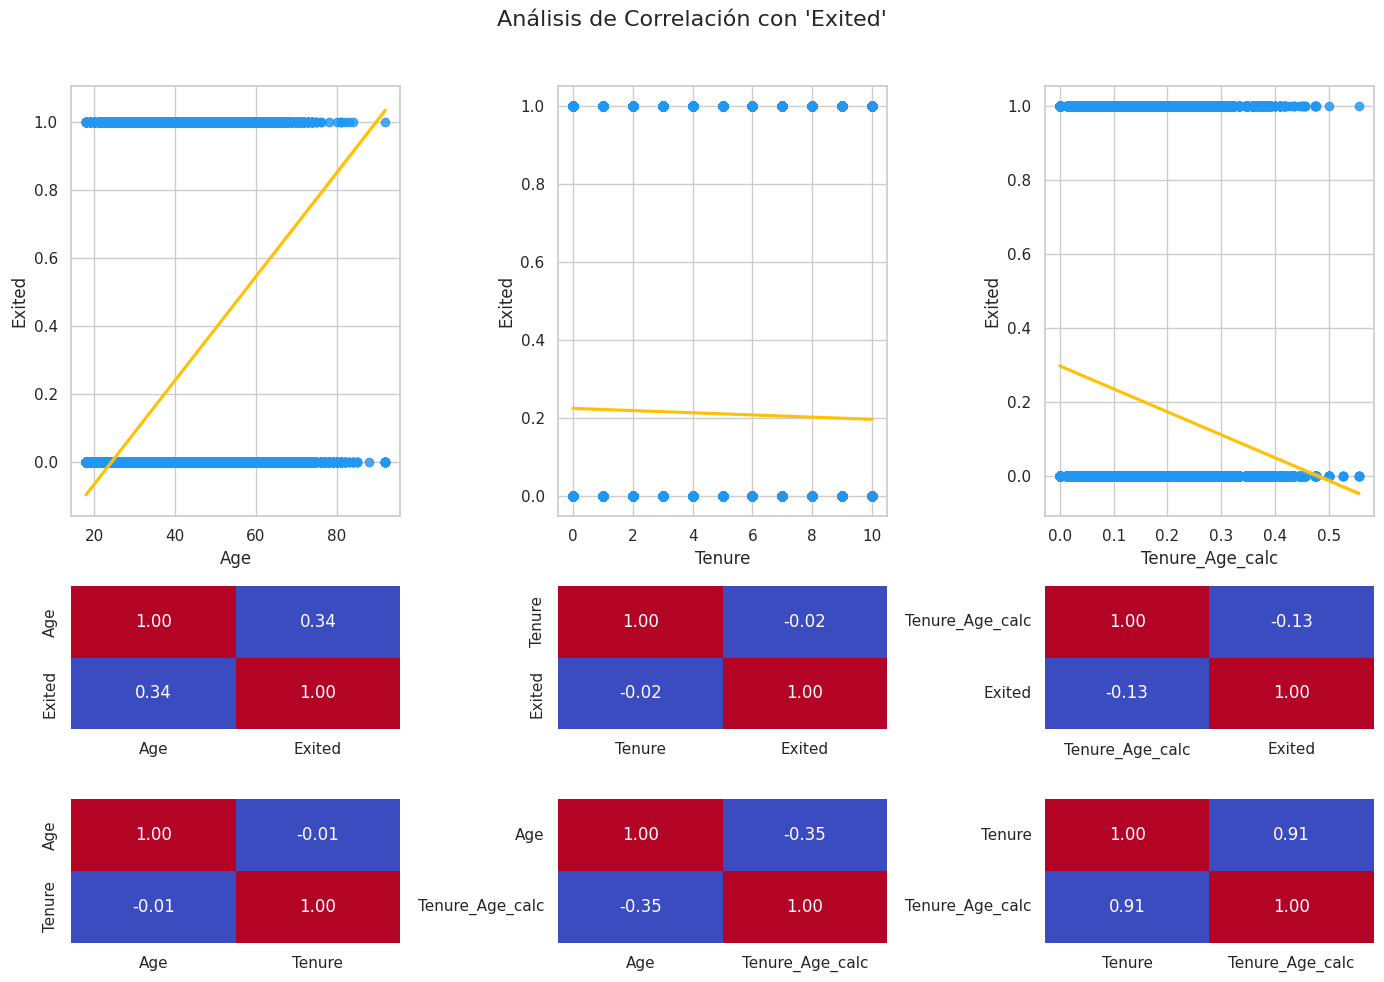

In [22]:
# GRÁFICOS DE REGRESIÓN Y MAPA DE CALOR DE CORRELACIÓN

# Establecer el estilo de Seaborn
sns.set_theme(style="whitegrid", palette="pastel")

# Crear subgráficos
fig, axis = plt.subplots(3, 3, figsize=(14, 10), gridspec_kw={'height_ratios': [6, 2, 2]})

# Configurar el título principal
plt.suptitle("Análisis de Correlación con 'Exited'", fontsize=16)

# Regplots y mapas de calor
sns.regplot(data=data_clean, x="Age", y="Exited", ax=axis[0, 0], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Tenure", y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Tenure_Age_calc", y="Exited", ax=axis[0, 2], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})

sns.heatmap(data_clean[["Age", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Tenure", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Tenure_Age_calc", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 2], cmap="coolwarm")

sns.heatmap(data_clean[["Age", "Tenure"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Age", "Tenure_Age_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Tenure", "Tenure_Age_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 2], cmap="coolwarm")

# Ajustar diseño
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Mostrar gráfico
plt.show()


Ya sabemos la relación entre Tenure_age Age y Tenure, lo que podemos observar con respecto a Exited, es que Tenure no tiene ningún tipo de correlación con ella, mientras que Age tiene una correlación alta de 0.34. La variable Tenure_Age tiene una correlación negativa de -0.13 que tiene pinta de venir por la variable Age por la correlación existente entre ambas.

Por tanto, **descartamos la variable Tenure_Age** como significativa de momento, si necesitamos más variables o mejorar el modelo, podría ser una variable a incluir, teniendo en mente la relación con Age.

* **Age_Tenure_product**

In [23]:
data_clean[['Age','Tenure','NumOfProducts','Age_Tenure_product']].head()

,Age,Tenure,NumOfProducts,Age_Tenure_product
0,33.0,3.0,2.0,99.0
1,33.0,1.0,2.0,33.0
2,40.0,10.0,2.0,400.0
3,34.0,2.0,1.0,68.0
4,33.0,5.0,2.0,165.0


Podemos observar que no tiene que ver con la variable NumOfProducts, que lo que significa es que es el producto entre Age y Tenure. Comprobamos lo mismo que con la variable anterior:

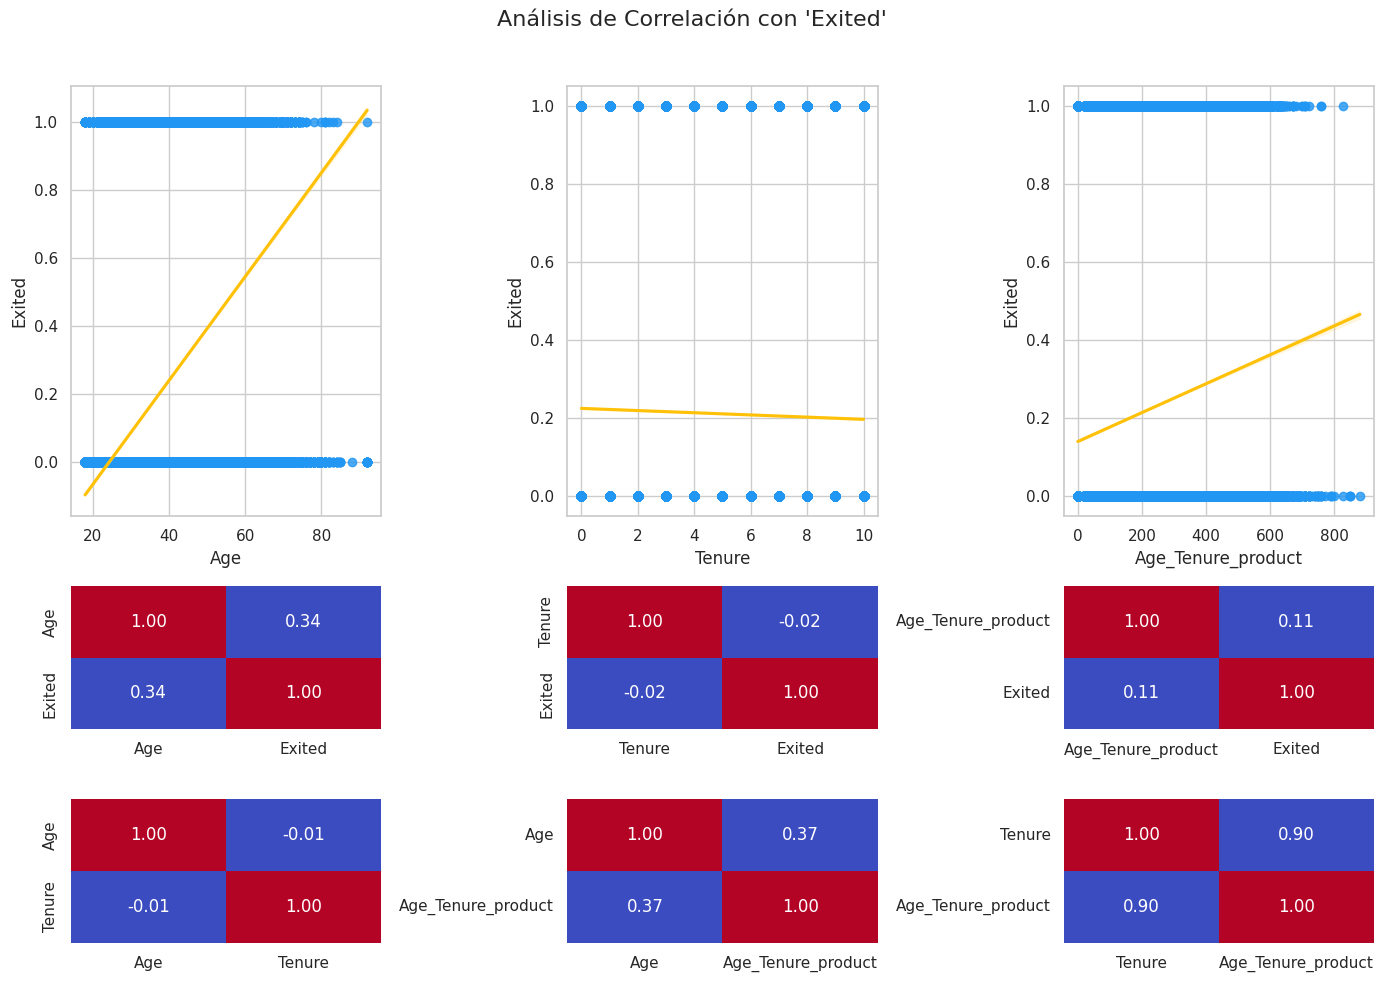

In [24]:
# GRÁFICOS DE REGRESIÓN Y MAPA DE CALOR DE CORRELACIÓN

sns.set_theme(style="whitegrid", palette="pastel")

fig, axis = plt.subplots(3, 3, figsize=(14, 10), gridspec_kw={'height_ratios': [6, 2, 2]})

plt.suptitle("Análisis de Correlación con 'Exited'", fontsize=16)

# Regplots y mapas de calor
sns.regplot(data=data_clean, x="Age", y="Exited", ax=axis[0, 0], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Tenure", y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Age_Tenure_product", y="Exited", ax=axis[0, 2], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})

sns.heatmap(data_clean[["Age", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Tenure", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Age_Tenure_product", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 2], cmap="coolwarm")

sns.heatmap(data_clean[["Age", "Tenure"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Age", "Age_Tenure_product"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Tenure", "Age_Tenure_product"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 2], cmap="coolwarm")


fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Las conclusiones son las mismas que con la variable Tenure_Age_calc. 

* **Mem__no__Products**

In [25]:
data_clean[['IsActiveMember','NumOfProducts','Mem__no__Products']].head()

,IsActiveMember,NumOfProducts,Mem__no__Products
0,0,2.0,0.0
1,1,2.0,2.0
2,0,2.0,0.0
3,1,1.0,1.0
4,1,2.0,2.0


En este caso, la variable Mem__no__Products= IsActiveMember*NumOfProducts. Analizamos igual que las anteriores

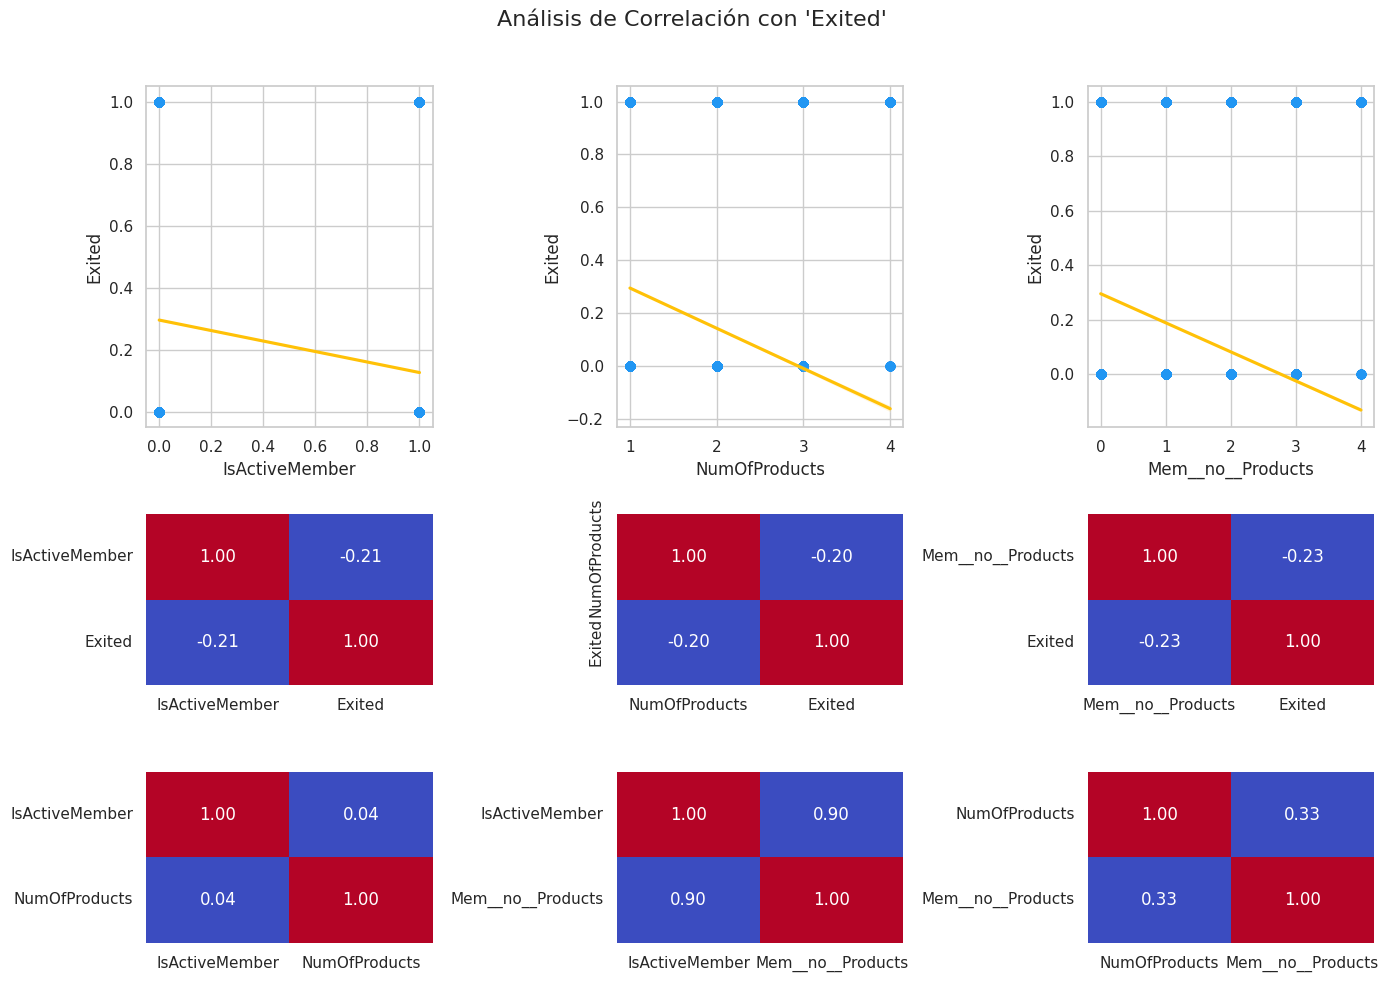

In [26]:
# GRÁFICOS DE REGRESIÓN Y MAPA DE CALOR DE CORRELACIÓN

sns.set_theme(style="whitegrid", palette="pastel")

fig, axis = plt.subplots(3, 3, figsize=(14, 10), gridspec_kw={'height_ratios': [10, 5, 5]})

plt.suptitle("Análisis de Correlación con 'Exited'", fontsize=16)

# Regplots y mapas de calor
sns.regplot(data=data_clean, x="IsActiveMember", y="Exited", ax=axis[0, 0], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="NumOfProducts", y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Mem__no__Products", y="Exited", ax=axis[0, 2], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})

sns.heatmap(data_clean[["IsActiveMember", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 0], cmap="coolwarm")
sns.heatmap(data_clean[["NumOfProducts", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Mem__no__Products", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 2], cmap="coolwarm")

sns.heatmap(data_clean[["IsActiveMember", "NumOfProducts"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 0], cmap="coolwarm")
sns.heatmap(data_clean[["IsActiveMember", "Mem__no__Products"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 1], cmap="coolwarm")
sns.heatmap(data_clean[["NumOfProducts", "Mem__no__Products"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 2], cmap="coolwarm")


fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

En este caso, las variables NumOfProducts y IsActiveMember no tienen ninguna relación entre ellas, mientras que con respecto a la variable objetivo están correlacionadas de manera negativa -0.20 y -0.21 respectivamente. Y con la variable Mem_no_Products está correlacionada en -0.23. 

Esto significa que tienen prácticamente la misma correlación por separado cada una, como si las juntamos. 
Podemos incluir en el modelo las variables por separado, o bien únicamente la variable combinación si necesitáramos reducir dimensiones. En este caso, no tenemos un exceso de variables, por tanto, **mantenemos las variables NumOfProducts y IsActiveMember** por separado y **descartamos Mem_no_Products** de momento, a la espera de ver si mejoraría el modelo. 

* **Cred_Bal_Sal** y **Bal_sal**

Transformación de variables object a numéricas:

Al transformar las variables object a numéricas se generan muchos NaN como hemos visto con la variable Tenure_Age, por tanto, hay que comprobar Cred_Bal_Sal y Bal_Sal, y EstimatedSalary para ver que no genere muchos NaN:

In [27]:
total_data_numeric = data_clean.apply(pd.to_numeric, errors='coerce')

pd.DataFrame({
    "Count_NaN": total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().sum(),
    "%_NaN": round(total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().sum()/total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().count()*100,2)})


,Count_NaN,%_NaN
Cred_Bal_Sal,81738,46.71
Bal_sal,81737,46.71
EstimatedSalary,2,0.00


La variable EstimatedSalary contiene 2 valores que no se pueden transformar a número, vemos en la tabla7 que esos valores corresponden con dos valores de Exited=0.

Tabla7:

In [28]:
data_clean[total_data_numeric["EstimatedSalary"].isna()]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Country_Labels,Tenure_Age_calc
53856,687.0,50.0,6.0,0.00,2.0,0,1,38.190.168,0,2.0,0.0,0.0,300.0,1,1,France,0.120000
159796,602.0,36.0,7.0,133800.98,2.0,1,0,14.012.017,0,0.0,"5.748.507.867.211.400,00","9.549.016.390.716.620,00",252.0,1,1,France,0.194444


Por tanto, directamente los eliminamos del dataset:

In [29]:
data_clean["EstimatedSalary"]=data_clean["EstimatedSalary"].apply(pd.to_numeric, errors='coerce')
data_clean = data_clean.dropna(subset=['EstimatedSalary'])
data_clean[total_data_numeric["EstimatedSalary"].isna()]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Country_Labels,Tenure_Age_calc


In [30]:
data_clean["EstimatedSalary"].info()

<class 'pandas.core.series.Series'>
Index: 174985 entries, 0 to 175027
Series name: EstimatedSalary
Non-Null Count   Dtype  
--------------   -----  
174985 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


Vemos que se generan muchos Nan en las variables Cred Bal Sal y Bal Sal, las analizamos por separado como Tenure_Age para ver cómo están calculadas y calcularlas de nuevo:

In [31]:
data_clean[["CreditScore","Balance","EstimatedSalary","Cred_Bal_Sal","Bal_sal"]].head()

,CreditScore,Balance,EstimatedSalary,Cred_Bal_Sal,Bal_sal
0,668.0,0.00,181449.97,0.0,0.0
1,627.0,0.00,49503.50,0.0,0.0
2,678.0,0.00,184866.69,0.0,0.0
3,581.0,148882.54,84560.88,"10.229.405.812.711.500,00","17.606.550.452.171.200,00"
4,716.0,0.00,15068.83,0.0,0.0


Tiene pinta de ser un producto de las variables, lo comprobamos y vemos que no corresponde, por tanto, probamos con la siguiente combinación posible: CreditScore*Balance/EstimatedSalary y Balance/EstimatedSalary. 

Esa es la combinación (ver *Tabla8*), por tanto, eliminamos las columnas que no se pueden transformar y dejamos las calculadas para los análisis:

Tabla8

In [32]:
df=pd.DataFrame({
    "Cred_Bal_Sal_calc": data_clean["CreditScore"]*data_clean["Balance"]/data_clean["EstimatedSalary"],
    "Bal_sal_calc": data_clean["Balance"]/data_clean["EstimatedSalary"]

})
subset_data_clean=data_clean[["CreditScore","Balance","EstimatedSalary","Cred_Bal_Sal","Bal_sal"]]

result = pd.concat([subset_data_clean, df], ignore_index=False,axis=1)
result.head(10)


,CreditScore,Balance,EstimatedSalary,Cred_Bal_Sal,Bal_sal,Cred_Bal_Sal_calc,Bal_sal_calc
0,668.0,0.00,181449.97,0.0,0.0,0.000000,0.000000
1,627.0,0.00,49503.50,0.0,0.0,0.000000,0.000000
2,678.0,0.00,184866.69,0.0,0.0,0.000000,0.000000
3,581.0,148882.54,84560.88,"10.229.405.812.711.500,00","17.606.550.452.171.200,00",1022.940581,1.760655
4,716.0,0.00,15068.83,0.0,0.0,0.000000,0.000000
5,588.0,131778.58,136024.31,"569.646.742.115.435,00","9.687.869.763.867.940,00",569.646742,0.968787
6,593.0,144772.69,29792.11,"2.881.642.326.441.460,00","4.859.430.567.354.910,00",2881.642326,4.859431
7,678.0,138476.41,106851.60,"8.786.672.916.456.090,00","12.959.694.567.044.300,00",878.667292,1.295969
8,676.0,0.00,142917.13,0.0,0.0,0.000000,0.000000
9,583.0,81274.33,170843.07,"2.773.477.109.138.810,00","47.572.506.160.185.400,00",277.347711,0.475725


In [33]:
data_clean["Cred_Bal_Sal_calc"]= data_clean["CreditScore"]*data_clean["Balance"]/data_clean["EstimatedSalary"]
data_clean["Bal_sal_calc"]= data_clean["Balance"]/data_clean["EstimatedSalary"]
data_clean.drop(["Cred_Bal_Sal","Bal_sal"],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Age_Tenure_product,Sex,Countries,Country_Labels,Tenure_Age_calc,Cred_Bal_Sal_calc,Bal_sal_calc
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,99.0,1,1,France,0.090909,0.000000,0.000000
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.50,0,2.0,33.0,1,1,France,0.030303,0.000000,0.000000
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,400.0,1,1,France,0.250000,0.000000,0.000000
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,68.0,1,1,France,0.058824,1022.940581,1.760655
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,165.0,1,3,Spain,0.151515,0.000000,0.000000


Seguimos con el análisis variables combinadas: Cred_Bal_Sal_calc, Bal_sal_calc ya transformadas

* **Cred_Bal_Sal** y **Bal_sal**

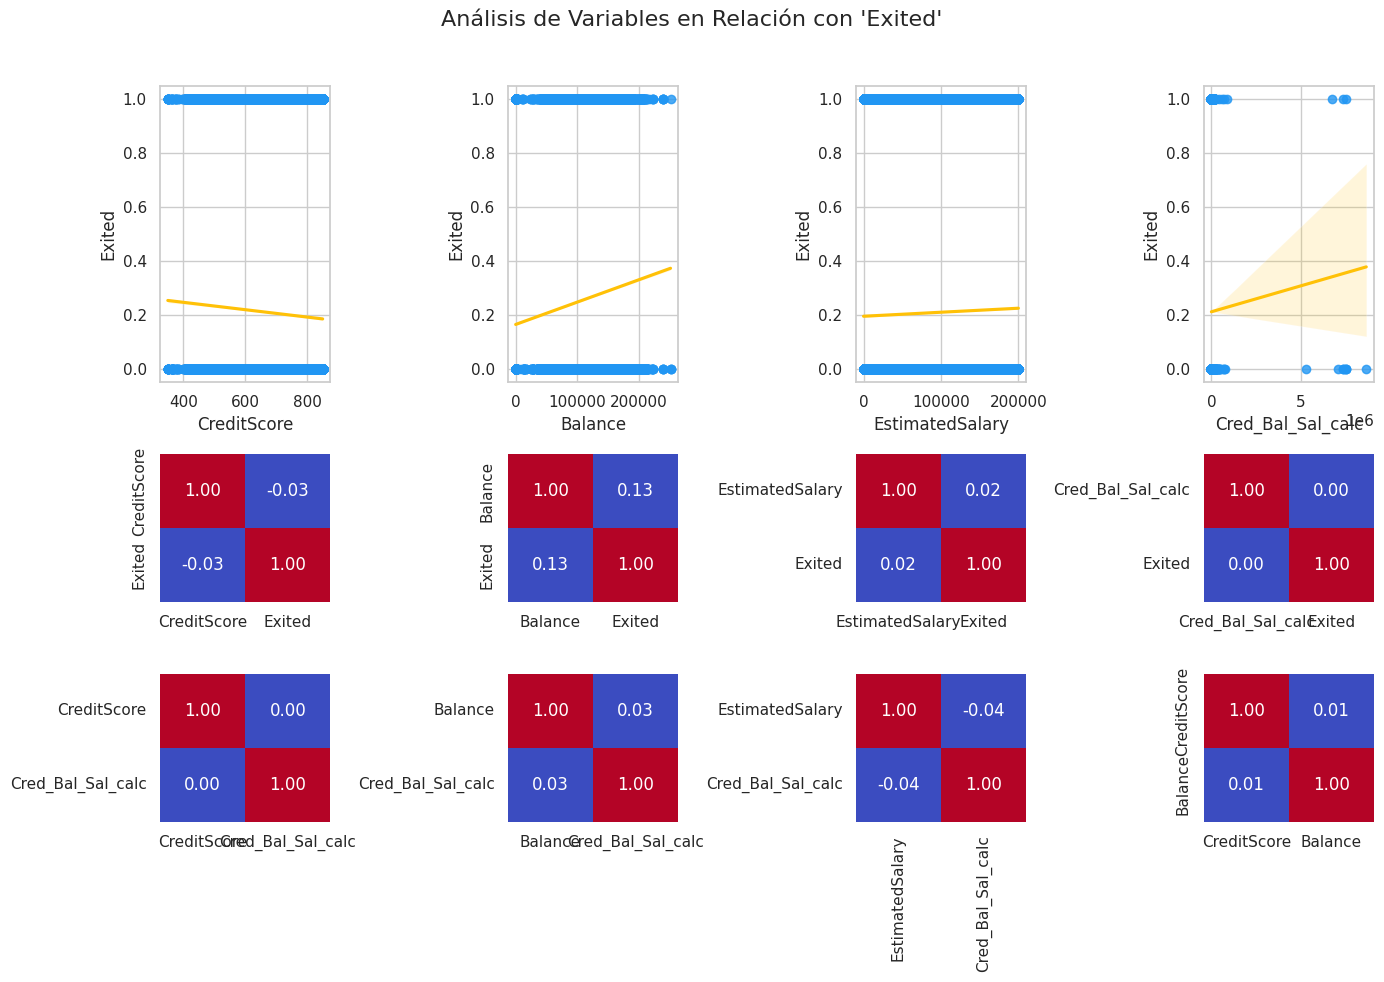

In [34]:
# GRÁFICOS DE REGRESIÓN Y MAPA DE CALOR DE CORRELACIÓN

fig, axis = plt.subplots(3, 4, figsize=(14, 10), gridspec_kw={'height_ratios': [8, 4, 4]})

plt.suptitle("Análisis de Variables en Relación con 'Exited'", fontsize=16)

sns.regplot(data=data_clean, x="CreditScore", y="Exited", ax=axis[0, 0], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Balance", y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="EstimatedSalary", y="Exited", ax=axis[0, 2], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Cred_Bal_Sal_calc", y="Exited", ax=axis[0, 3], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})

sns.heatmap(data_clean[["CreditScore", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 2], cmap="coolwarm")
sns.heatmap(data_clean[["Cred_Bal_Sal_calc", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 3], cmap="coolwarm")

sns.heatmap(data_clean[["CreditScore", "Cred_Bal_Sal_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Cred_Bal_Sal_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 1], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Cred_Bal_Sal_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 2], cmap="coolwarm")
sns.heatmap(data_clean[["CreditScore", "Balance"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 3], cmap="coolwarm")


fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

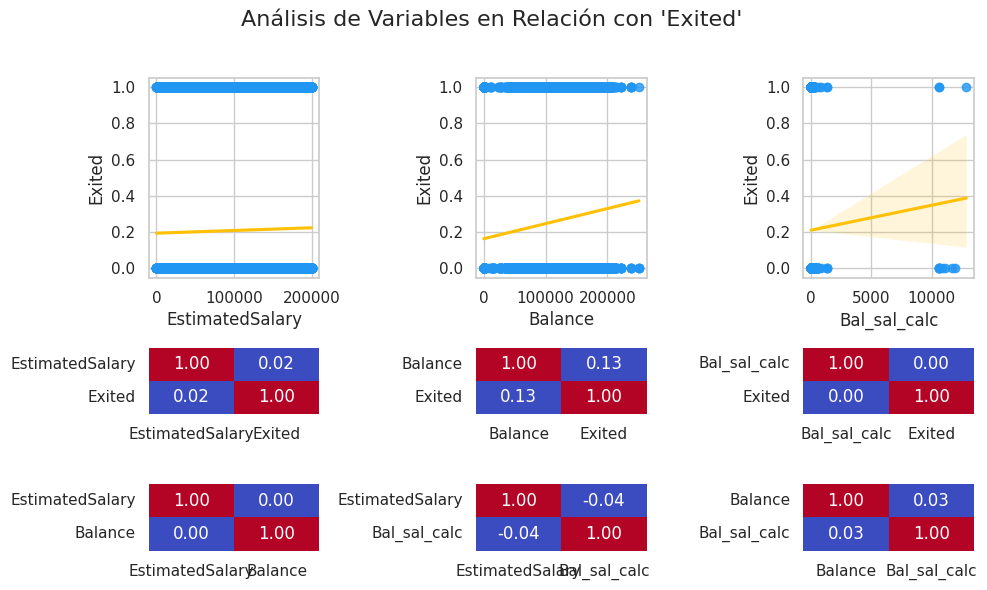

In [35]:

fig, axis = plt.subplots(3, 3, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 2, 2]})

plt.suptitle("Análisis de Variables en Relación con 'Exited'", fontsize=16)

sns.regplot(data=data_clean, x="EstimatedSalary", y="Exited", ax=axis[0, 0], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Balance", y="Exited", ax=axis[0, 1], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})
sns.regplot(data=data_clean, x="Bal_sal_calc", y="Exited", ax=axis[0, 2], scatter_kws={"color": "#2196F3"}, line_kws={"color": "#FFC107"})

sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 0], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Bal_sal_calc", "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 2], cmap="coolwarm")

sns.heatmap(data_clean[["EstimatedSalary", "Balance"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 0], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Bal_sal_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 1], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Bal_sal_calc"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[2, 2], cmap="coolwarm")

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Al observar las dos partes de gráficos comparando las variables independientes con las combinadas respecto a 'Excited' comprobamos que una correlación del 0.00 entre las variables Cred_Bal_Sal_calc y Bal_sal_calc con la variable Exited indica que no hay una relación lineal aparente entre estas variables y la probabilidad de que un cliente abandone (Exited).

Esto significa que, según el análisis de correlación lineal, no hay una relación sistemática y lineal entre la combinación de CreditScore * Balance / EstimatedSalary (representada por Cred_Bal_Sal_calc) o Balance / EstimatedSalary (representada por Bal_sal_calc) y la variable objetivo Exited.

Vamos a analizar estas variables calculadas por separado para ver outliers:

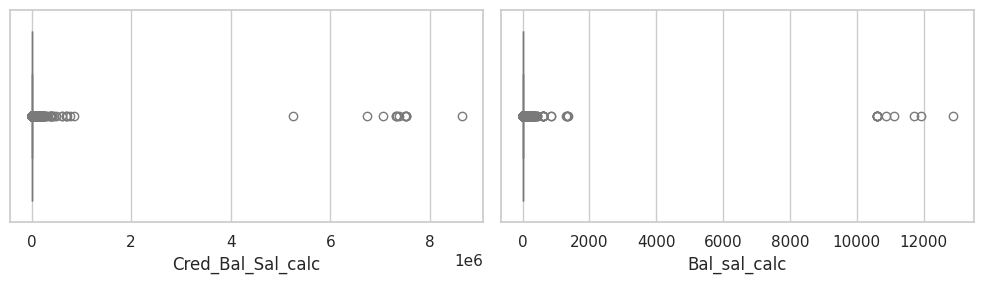

In [36]:
# DIAGRAMA DE CAJAS

fig, axis = plt.subplots(1,2,figsize=(10,3))
sns.boxplot(data=data_clean, x="Cred_Bal_Sal_calc",ax=axis[0])
sns.boxplot(data=data_clean, x="Bal_sal_calc",ax=axis[1])
plt.tight_layout()
plt.show()


Podemos observar que en ambos casos hay una existencia de outliers que distorsionan las distribuciones de las variables. Los visualizamos en los siguientes graficos:


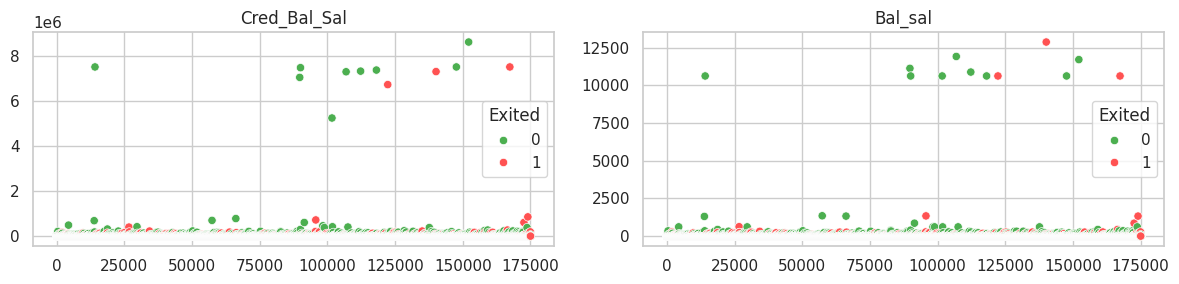

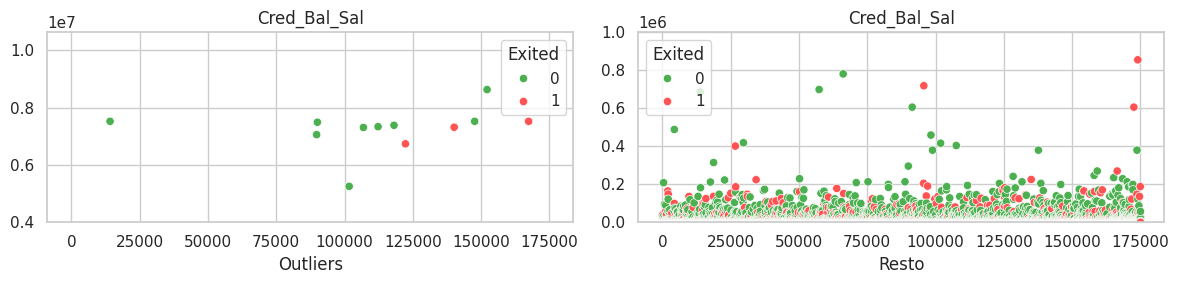

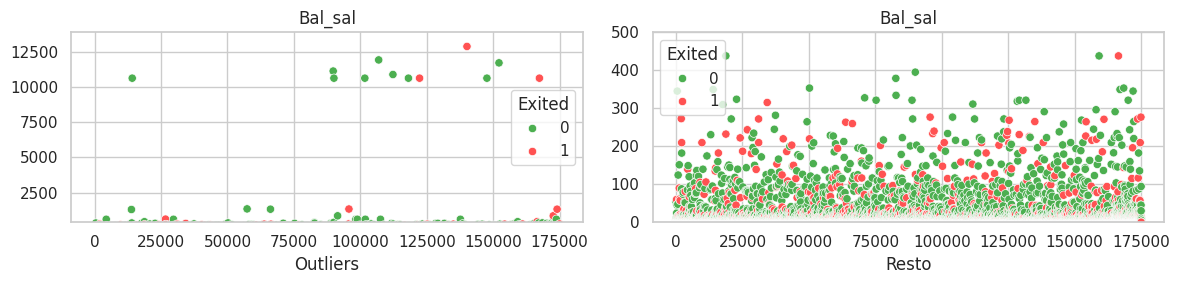

In [37]:
# GRÁFICO DE DISPERSIÓN

categoria = data_clean['Exited'].astype('category')

colors = ["#4CAF50", "#FF5252"]

# Primer conjunto de gráficos
fig, axis = plt.subplots(1, 2, figsize=(12, 3))
max1 = data_clean["Cred_Bal_Sal_calc"].max() + 2000000
min1 = data_clean["Cred_Bal_Sal_calc"].min()
max2 = data_clean["Bal_sal_calc"].max() + 1000
min2 = data_clean["Bal_sal_calc"].min()

sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index, y=data_clean["Cred_Bal_Sal_calc"], hue=categoria, palette=colors, ax=axis[0])
sns.scatterplot(x=data_clean["Bal_sal_calc"].index, y=data_clean["Bal_sal_calc"], hue=categoria, palette=colors, ax=axis[1])

axis[0].set_xlabel("")
axis[0].set_title("Cred_Bal_Sal")
axis[0].set_ylabel("")
axis[1].set_xlabel("")
axis[1].set_ylabel("")
axis[1].set_title("Bal_sal")
plt.tight_layout()
plt.show()

# Segundo conjunto de gráficos
fig, axis = plt.subplots(1, 2, figsize=(12, 3))
sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index, y=data_clean["Cred_Bal_Sal_calc"], hue=categoria, palette=colors, ax=axis[0])
axis[0].set_ylim(4000000, max1)
axis[0].set_title("Cred_Bal_Sal")
sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index, y=data_clean["Cred_Bal_Sal_calc"], hue=categoria, palette=colors, ax=axis[1])
axis[1].set_ylim(min1, 1000000)
axis[1].set_title("Cred_Bal_Sal")
axis[0].set_xlabel("Outliers")
axis[0].set_ylabel("")
axis[1].set_xlabel("Resto")
axis[1].set_ylabel("")
plt.tight_layout()
plt.show()

# Tercer conjunto de gráficos
fig, axis = plt.subplots(1, 2, figsize=(12, 3))
sns.scatterplot(x=data_clean["Bal_sal_calc"].index, y=data_clean["Bal_sal_calc"], hue=categoria, palette=colors, ax=axis[0])
axis[0].set_ylim(400, max2)
axis[0].set_title("Bal_sal")
sns.scatterplot(x=data_clean["Bal_sal_calc"].index, y=data_clean["Bal_sal_calc"], hue=categoria, palette=colors, ax=axis[1])
axis[1].set_ylim(min2, 500)
axis[1].set_title("Bal_sal")
axis[0].set_xlabel("Outliers")
axis[0].set_ylabel("")
axis[1].set_xlabel("Resto")
axis[1].set_ylabel("")
plt.tight_layout()
plt.show()

Podemos observar que los outliers contienen algunos datos de abandonos, y tienen pinta de ser el mismo cliente, por tanto, vamos a llevar esos outliers a la media. 

La media, a pesar de tener estas dos variables más del 50% de los datos en 0, es una media elevada en el caso de Cred_Bal_Sal, debido a la diferencia de rango de los outliers que distorsionan esa media. En este caso, nos viene bien que la media sea ese valor para no llevar a los outliers a un valor demasiado pequeño. 

En el caso de Bal_sal observamos que el número de outliers es muy bajo (menos de un 0,1%), vamos a trabajar con un 1% de los outliers de Cred_Bal_Sal y un 0,1% de los de Bal_sal y a ver si con esos ya tenemos una distribución más homogénea. (*Tabla9*)

Tabla9 - Vemos los diferentes percentiles a partir del 0.95 para poder decidir dónde poner el corte:

In [38]:
# Calcula los percentiles adicionales
percentiles = [0.9, 0.95,0.99,0.999]
additional_perc1 = data_clean["Bal_sal_calc"].quantile(percentiles)
additional_perc2 = data_clean["Cred_Bal_Sal_calc"].quantile(percentiles)

describe_with_perc1 = data_clean["Bal_sal_calc"].describe()
describe_with_perc1.loc["90%"] = additional_perc1.loc[0.90]
describe_with_perc1.loc["95%"] = additional_perc1.loc[0.95]
describe_with_perc1.loc["99%"] = additional_perc1.loc[0.99]
describe_with_perc1.loc["99,9%"] = additional_perc1.loc[0.999]

describe_with_perc2 = data_clean["Cred_Bal_Sal_calc"].describe()
describe_with_perc2.loc["90%"] = additional_perc2.loc[0.90]
describe_with_perc2.loc["95%"] = additional_perc2.loc[0.95]
describe_with_perc2.loc["99%"] = additional_perc2.loc[0.99]
describe_with_perc2.loc["99,9%"] = additional_perc2.loc[0.999]

info_combined = pd.concat([describe_with_perc2.round(3), describe_with_perc1.round(3)], axis=1)

print(info_combined)

       Cred_Bal_Sal_calc  Bal_sal_calc
count         174985.000    174985.000
mean            1444.306         2.202
std            60979.725        92.691
min                0.000         0.000
25%                0.000         0.000
50%                0.000         0.000
75%              658.642         1.000
max          8634204.107     12863.796
90%             1213.756         1.845
95%             1854.949         2.790
99%            10523.192        15.997
99,9%         114751.142       173.563


Analizamos en los siguientes gráficos: cuál es la mayor correlación obtenida con la variable objetivo, si eliminamos los outliers desde el percentil 0.9 al 0.99 tomando sucesivos grupos de 0.01 en 0.01:

In [39]:
quant=np.arange(0.90, 1, 0.01)

mean1=data_clean["Cred_Bal_Sal_calc"].mean()
mean2=data_clean["Bal_sal_calc"].mean()
corr1=[]
per1=[]
corr2=[]
per2=[]
for i in range(len(quant)):
    per1.append(data_clean["Cred_Bal_Sal_calc"].quantile(quant[i]))
    data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per1[i] else mean1)
    corr1.append(data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"]))

for i in range(len(quant)):
    per2.append(data_clean["Bal_sal_calc"].quantile(quant[i]))
    data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per2[i] else mean2)
    corr2.append(data_clean["Bal_sal_out"].corr(data_clean["Exited"]))


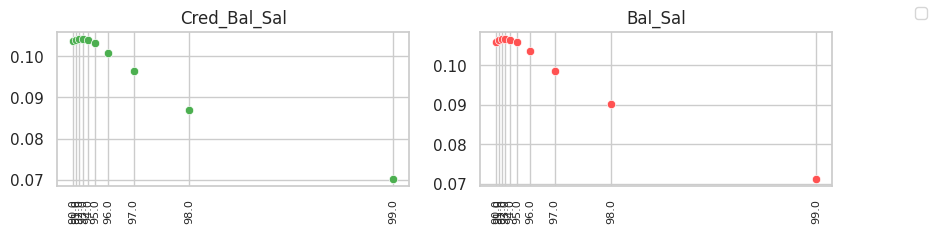

In [40]:
# GRÁFICO DE DISPERSIÓN

fig, axis = plt.subplots(1, 2, figsize=(10, 2))

# Primer gráfico
scatter1 = sns.scatterplot(x=per1, y=corr1, ax=axis[0], color=colors[0])
axis[0].set_xticks(per1, labels=(quant * 100).round(3), rotation=90, fontsize=8)
axis[0].set_title("Cred_Bal_Sal")

# Segundo gráfico
scatter2 = sns.scatterplot(x=per2, y=corr2, ax=axis[1], color=colors[1])
axis[1].set_xticks(per2, labels=(quant * 100).round(3), rotation=90, fontsize=8)
axis[1].set_title("Bal_Sal")

# Añadir leyenda
fig.legend(handles=[scatter1, scatter2], labels=["Exited = 0", "Exited = 1"], loc='upper right')

plt.show()

In [41]:
print(f"'Cred_Bal_Sal' maxima correlación: {max(corr1).round(3)} en percentil: {quant[corr1.index(max(corr1))]}")
print(f"'Bal_sal' maxima correlación: {max(corr2).round(3)} en percentil: {quant[corr2.index(max(corr2))]}")

'Cred_Bal_Sal' maxima correlación: 0.104 en percentil: 0.93
'Bal_sal' maxima correlación: 0.107 en percentil: 0.93


Comprobamos que la **mayor correlación** la tenemos en ambas variables en el **percentil 0.93**

En el siguiente código vamos a ver si podemos no perder demasiada correlación pero apurar más la pérdida de datos:

In [42]:
quant=np.arange(0.92, 0.99, 0.01)

mean1=data_clean["Cred_Bal_Sal_calc"].mean()
mean2=data_clean["Bal_sal_calc"].mean()
corr1=[]
per1=[]
corr2=[]
per2=[]
for i in range(len(quant)):
    per1.append(data_clean["Cred_Bal_Sal_calc"].quantile(quant[i]))
    data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per1[i] else mean1)
    corr1.append(data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"]))

for i in range(len(quant)):
    per2.append(data_clean["Bal_sal_calc"].quantile(quant[i]))
    data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per2[i] else mean2)
    corr2.append(data_clean["Bal_sal_out"].corr(data_clean["Exited"]))

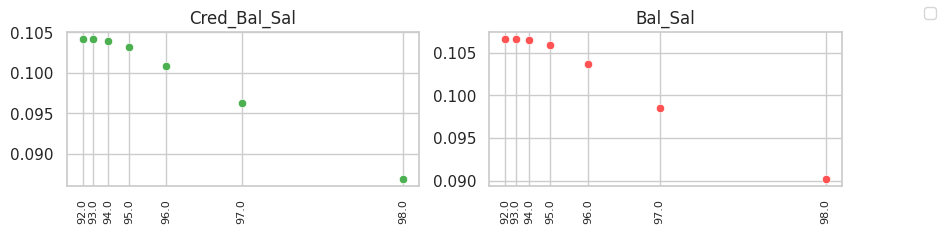

In [43]:
# GRÁFICO DE DISPERSIÓN

fig, axis = plt.subplots(1, 2, figsize=(10, 2))

# Primer gráfico
scatter1 = sns.scatterplot(x=per1, y=corr1, ax=axis[0], color=colors[0])
axis[0].set_xticks(per1, labels=(quant * 100).round(3), rotation=90, fontsize=8)
axis[0].set_title("Cred_Bal_Sal")

# Segundo gráfico
scatter2 = sns.scatterplot(x=per2, y=corr2, ax=axis[1], color=colors[1])
axis[1].set_xticks(per2, labels=(quant * 100).round(3), rotation=90, fontsize=8)
axis[1].set_title("Bal_Sal")

# Añadir leyenda
fig.legend(handles=[scatter1, scatter2], labels=["Exited = 0", "Exited = 1"], loc='upper right')

plt.show()

Sin perder mucha correlacion podriamos ir a transformar los outliers por encima del 95%:

In [44]:
per95_1=data_clean["Cred_Bal_Sal_calc"].quantile(0.95)
data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per95_1 else mean1)
corr_1=data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"])

per95_2=data_clean["Bal_sal_calc"].quantile(0.95)
data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per95_2 else mean2)
corr_2=data_clean["Bal_sal_out"].corr(data_clean["Exited"])

print(f"'Cred_Bal_Sal' correlación: {corr_1.round(3)} en percentil 95")
print(f"'Bal_Sal' correlación: {corr_2.round(3)} en percentil 95")



'Cred_Bal_Sal' correlación: 0.103 en percentil 95
'Bal_Sal' correlación: 0.106 en percentil 95


**Analizamos** las variables **Cred_Bal_Sal** y **Bal_sal** ya transformadas sin outliers, para ver cómo han mejorado las correlaciones

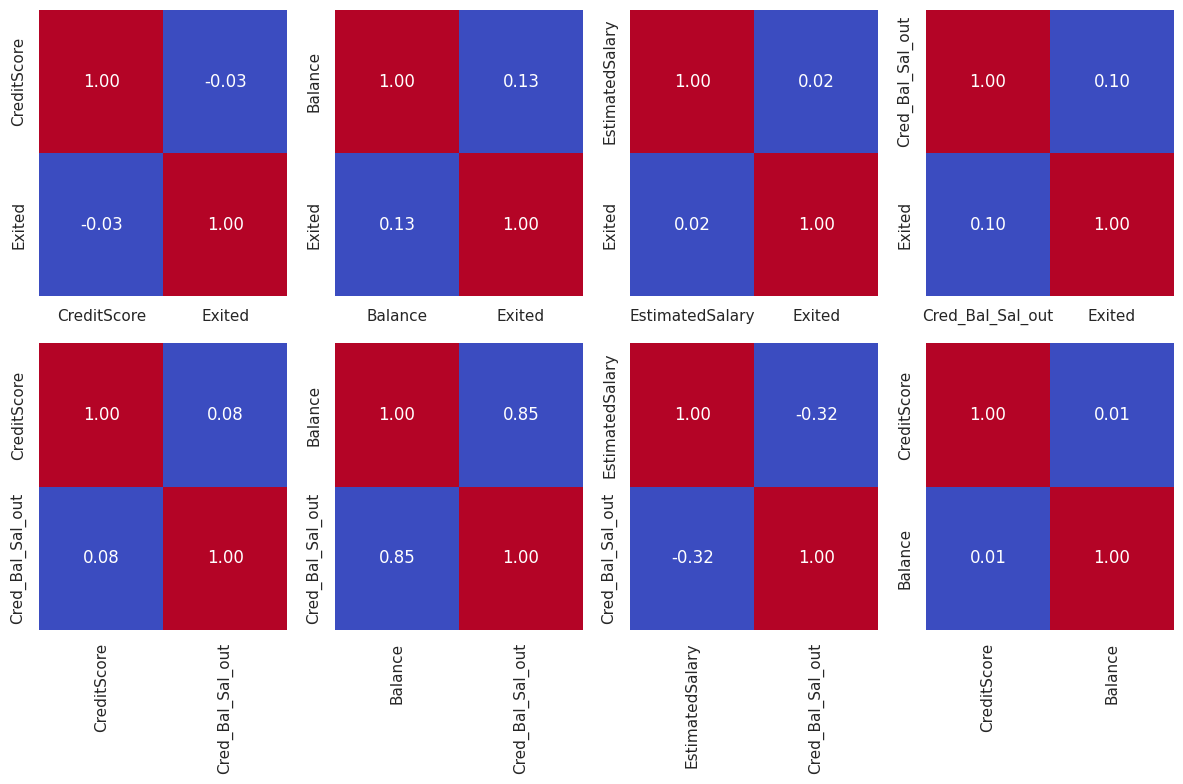

In [45]:
# MAPA DE CALOR DE CORRELACIÓN

fig, axis = plt.subplots(2,4, figsize=(12,8))


sns.heatmap(data_clean[["CreditScore", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,0], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,1], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,2], cmap="coolwarm")
sns.heatmap(data_clean[["Cred_Bal_Sal_out", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,3], cmap="coolwarm")

sns.heatmap(data_clean[["CreditScore", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0], cmap="coolwarm")
sns.heatmap(data_clean[["Balance", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2], cmap="coolwarm")
sns.heatmap(data_clean[["CreditScore", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,3], cmap="coolwarm")
axis[1,0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=90)
axis[1,1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=90)
axis[1,2].set_xticklabels(axis[1,2].get_xticklabels(), rotation=90)
axis[1,3].set_xticklabels(axis[1,3].get_xticklabels(), rotation=90)

fig.tight_layout()
fig.show()

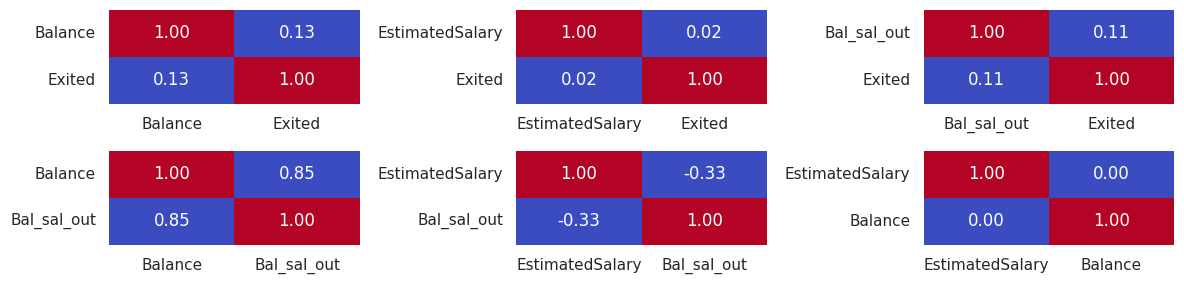

In [46]:
# MAPA DE CALOR DE CORRELACIÓN

fig, axis = plt.subplots(2,3, figsize=(12, 3))


sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,0], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,1], cmap="coolwarm")
sns.heatmap(data_clean[["Bal_sal_out", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,2], cmap="coolwarm")

sns.heatmap(data_clean[["Balance", "Bal_sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Bal_sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1], cmap="coolwarm")
sns.heatmap(data_clean[["EstimatedSalary", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2], cmap="coolwarm")


fig.tight_layout()
fig.show()

Análisis final de Cred_Bal_Sal y Bal_sal:

Finalmente, tratando los outliers de ambas variables, hemos conseguido una correlación mayor con la variable objetivo (0.11 y 0.10) así como con sus variables dependientes (CreditScore/Balance/EstimatedSalary y Balance/EstimatedSalary respectivamente) sobre todo podemos observar que la mayor relación la tienen con Balance y hemos conseguido una relación con EstimatedSalary, lo cual es interesante de cara a poder incluir esta variable en el modelo a través de alguna de estas dos.


Un análisis de correlación utilizando un gráfico de mapa de calor nos proporciona información valiosa sobre las relaciones entre las variables del conjunto de datos comparandolo con la variable objetivo "Excited".



Aquí tenemos el mapa completo de correlación entre todas las variables ya analizadas:

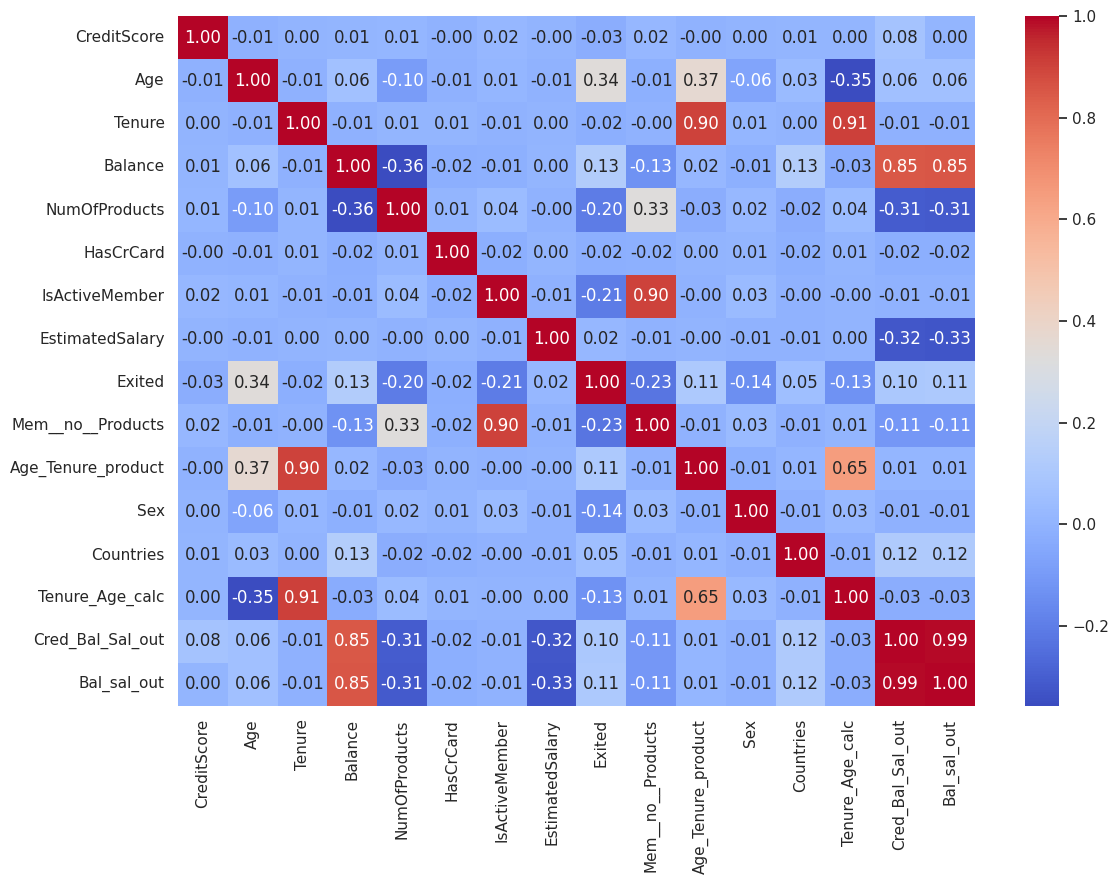

In [47]:
# MAPA DE CALOR DE CORRELACIÓN

fig, axis = plt.subplots(figsize=(12, 9))

# Incluir todas las columnas en el análisis de correlación
data_clean.drop(["Country_Labels","Cred_Bal_Sal_calc","Bal_sal_calc"],axis=1,inplace=True)

sns.heatmap(data_clean.corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.tight_layout()
plt.show()

Guardamos el dataset ya tratado

In [48]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174985 entries, 0 to 175027
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CreditScore         174985 non-null  float64
 1   Age                 174985 non-null  float64
 2   Tenure              174985 non-null  float64
 3   Balance             174985 non-null  float64
 4   NumOfProducts       174985 non-null  float64
 5   HasCrCard           174985 non-null  int64  
 6   IsActiveMember      174985 non-null  int64  
 7   EstimatedSalary     174985 non-null  float64
 8   Exited              174985 non-null  int64  
 9   Mem__no__Products   174985 non-null  float64
 10  Age_Tenure_product  174985 non-null  float64
 11  Sex                 174985 non-null  int64  
 12  Countries           174985 non-null  int64  
 13  Tenure_Age_calc     174985 non-null  float64
 14  Cred_Bal_Sal_out    174985 non-null  float64
 15  Bal_sal_out         174985 non-null  fl

In [49]:
data_clean.to_csv("/workspaces/Isa-Project/data/data_clean.csv")

**Resumen** Entrada de variables en el modelo: 

Leyenda:
* **Candidata**: variable a incluir en los modelos.
* **Descartada**: variable que NO vamos a incluir en los modelos.


**Entrada de variables en el modelo:**

* Age - **Candidata**           Correlación 0.34
* Tenure - **Descartada**       Correlación -0.01
* NumOfProducts - **Candidata**       Correlación -0.20
* IsActiveMember - **Candidata**       Correlación -0.21
* Sex - **Candidata**       Correlación -0.14
* CreditScore - **Descartada**      Correlación -0.03
* Balance - **Candidata**       Correlación 0.13
* Countries - **Candidata** Por lo explicado en Tabla7 y Grafico1
* EstimatedSalary - **Descartada**      Correlación 0.02
* HasCrCard - **Descartada**        Correlación -0.02

* Tenure_Age - **Descartada**       Correlación -0.13
* Age_Tenure_product - **Descartada**       Correlación 0.11
* Mem__no__Products - **Candidata**       Correlación -0.23
* Cred_Bal_Sal - **Candidata**       Correlación 0.10
* Bal_sal - **Candidata**       Correlación 0.11

# MODELADO

Para el caso de un modelo con una variable objetivo dicotómica, podemos empezar testando los siguientes modelos:

* Regresión logística

* *Random Forest*

* Bayes: Bernouilli y Gauss

* Árbol de decisión

* K-vecinos cercanos

* Boosting

 

Primero, separamos el dataset con las variables a incluir en el modelo:

Age, NumOfProducts, IsActiveMember, Sex, Balance, Countries, Mem__no__Products, Cred_Bal_Sal, Bal_sal

In [50]:
vars_mod=["Age", "NumOfProducts", "IsActiveMember", "Sex", "Balance", "Countries", "Mem__no__Products","Cred_Bal_Sal_out", "Bal_sal_out"]

y=data_clean["Exited"]
X=data_clean[vars_mod]

Separamos las muestras de entrenamiento y test:

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Normalizamos los datos:

In [52]:
 
scaler = StandardScaler()
scaler.fit(X_train)

cols=X.columns
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)

**REGRESIÓN LOGÍSTICA**

In [53]:
#Regresión
model = LogisticRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

#Lasso
lasso_model = Lasso(alpha = 0.1, max_iter = 300)
lasso_model.fit(X_train_norm, y_train)
y_pred_lasso = lasso_model.predict(X_test_norm)

#Ridge
ridge_model = Ridge(alpha = 0.1, max_iter = 300)
ridge_model.fit(X_train_norm, y_train)
y_pred_ridge = ridge_model.predict(X_test_norm)

Métricas de Regresión Logística:

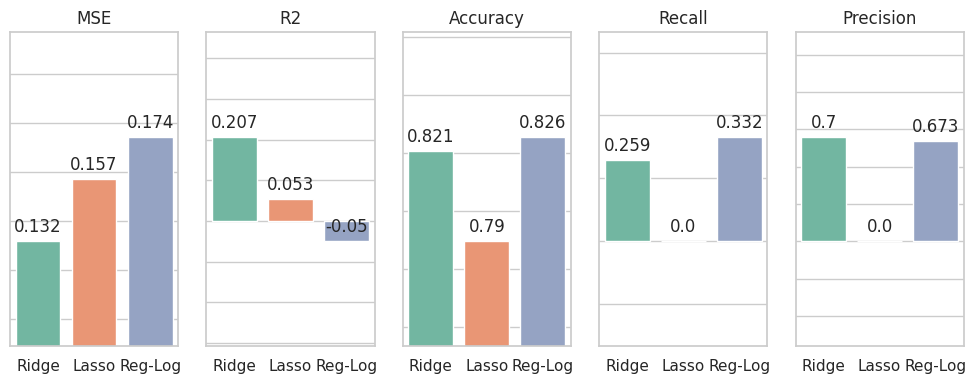

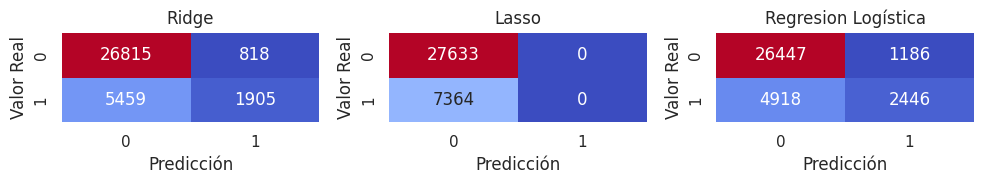

In [54]:
y_pred_ridge_round=y_pred_ridge.round(0)
y_pred_lasso_round=y_pred_lasso.round(0)

# Calcular el error cuadrático medio
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
MSE= mean_squared_error(y_test, y_pred)

#Calcular el R2
ridge_r2=r2_score(y_test, y_pred_ridge)
lasso_r2=r2_score(y_test, y_pred_lasso)
R2=r2_score(y_test, y_pred)

#Calcular el accuracy
ridge_acc=accuracy_score(y_test, y_pred_ridge_round)
lasso_acc=accuracy_score(y_test, y_pred_lasso_round)
model_acc=accuracy_score(y_test, y_pred)

#Calcular la matriz de confusión
ridge_conf=cm = confusion_matrix(y_test, y_pred_ridge_round)
lasso_conf=confusion_matrix(y_test, y_pred_lasso_round)
model_conf=confusion_matrix(y_test, y_pred)

#Calcular el recall
ridge_rec=recall_score(y_test, y_pred_ridge_round)
lasso_rec=recall_score(y_test, y_pred_lasso_round)
model_rec=recall_score(y_test, y_pred)

#Calcular la precisión
ridge_prec=precision_score(y_test, y_pred_ridge_round)
lasso_prec=precision_score(y_test, y_pred_lasso_round)
model_prec=precision_score(y_test, y_pred)


valoresMSE=[ridge_mse,lasso_mse,MSE]
valoresR2=[ridge_r2,lasso_r2,R2]
valoresAcc=[ridge_acc,lasso_acc,model_acc]
valoresRec=[ridge_rec,lasso_rec,model_rec]
valoresPrec=[ridge_prec,lasso_prec,model_prec]

nombs=['Ridge','Lasso','Reg-Log']

sns.set_theme(style="whitegrid", palette="pastel")
fig, axis= plt.subplots(1,5,figsize=(10,4))

#FILA 1
## 1º GRÁFICO - ERROR CUADRÁTICO MEDIO

ax1=sns.barplot(x=nombs,y=valoresMSE,hue=nombs,ax=axis[0],palette="Set2")
lim0=min(valoresMSE)-(max(valoresMSE)-min(valoresMSE))
lim1=max(valoresMSE)+(max(valoresMSE)-min(valoresMSE))
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
axis[0].set_yticklabels([])
axis[0].set_ylim(lim0,lim1)
axis[0].set_title("MSE")

## 2º GRÁFICO - R2
ax2=sns.barplot(x=nombs,y=valoresR2,hue=nombs,ax=axis[1],palette="Set2")
lim0=min(valoresR2)-(max(valoresR2)-min(valoresR2))
lim1=max(valoresR2)+(max(valoresR2)-min(valoresR2))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[1].set_yticklabels([])
axis[1].set_ylim(lim0,lim1)
axis[1].set_title("R2")

## 3º GRÁFICO - ACCURACY
ax2=sns.barplot(x=nombs,y=valoresAcc,hue=nombs,ax=axis[2],palette="Set2")
lim0=min(valoresAcc)-(max(valoresAcc)-min(valoresAcc))
lim1=max(valoresAcc)+(max(valoresAcc)-min(valoresAcc))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[2].set_yticklabels([])
axis[2].set_ylim(lim0,lim1)
axis[2].set_title("Accuracy")

## 4º GRÁFICO - RECALL
ax2=sns.barplot(x=nombs,y=valoresRec,hue=nombs,ax=axis[3],palette="Set2")
lim0=min(valoresRec)-(max(valoresRec)-min(valoresRec))
lim1=max(valoresRec)+(max(valoresRec)-min(valoresRec))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[3].set_yticklabels([])
axis[3].set_ylim(lim0,lim1)
axis[3].set_title("Recall")

## 5º GRÁFICO - PRECISIÓN
ax2=sns.barplot(x=nombs,y=valoresPrec,hue=nombs,ax=axis[4],palette="Set2")
lim0=min(valoresPrec)-(max(valoresPrec)-min(valoresPrec))
lim1=max(valoresPrec)+(max(valoresPrec)-min(valoresPrec))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[4].set_yticklabels([])
axis[4].set_ylim(lim0,lim1)
axis[4].set_title("Precision")

plt.tight_layout()
plt.show()

#FILA 2

fig, axis= plt.subplots(1,3,figsize=(10,2))
## 1º GRÁFICO

sns.heatmap(ridge_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[0].set_xlabel('Predicción')
axis[0].set_ylabel('Valor Real')
axis[0].set_title('Ridge')

sns.heatmap(lasso_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1].set_xlabel('Predicción')
axis[1].set_ylabel('Valor Real')
axis[1].set_title('Lasso')

sns.heatmap(model_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[2],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[2].set_xlabel('Predicción')
axis[2].set_ylabel('Valor Real')
axis[2].set_title('Regresion Logística')

plt.tight_layout()
plt.show()

Vemos que el mejor modelo habiendo testado la regularización es el **modelo de regresión logística** con un **accuracy de 82,55%** aunque tenemos un R2 muy bajo, el recall de este modelo es mejor que el de Ridge que tiene un R2 más aceptable. 

Veamos más modelos:

**RANDOM FOREST**

In [55]:
model_RF = RandomForestClassifier(random_state = 42)
model_RF.fit(X_train_norm, y_train)
y_pred_RF = model_RF.predict(X_test_norm)

Métricas de Random Forest, comparativa con el modelo seleccionado anteriormente: Regresión logística

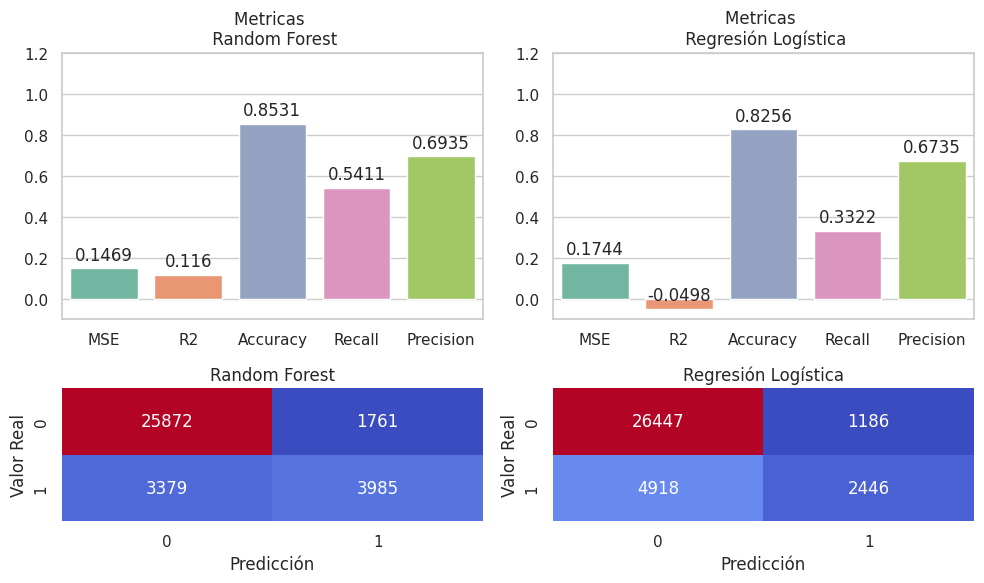

In [56]:

MSE_RF= mean_squared_error(y_test, y_pred_RF)
R2_RF=r2_score(y_test, y_pred_RF)
model_acc_RF=accuracy_score(y_test, y_pred_RF)
rec_RF=recall_score(y_test, y_pred_RF)
prec_RF=precision_score(y_test, y_pred_RF)

RF_conf=confusion_matrix(y_test, y_pred_RF)

valores_model=[MSE,R2,model_acc,model_rec,model_prec]
valores_RF=[MSE_RF,R2_RF,model_acc_RF,rec_RF,prec_RF]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Random Forest')

ax1=sns.barplot(x=nombs,y=valores_model,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Regresión Logística")

sns.heatmap(model_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Regresión Logística')

plt.tight_layout()
plt.show()

Este modelo mejora razonablemente todas las métricas del anterior, y lo hace mucho más robusto con un R2 de 0.11. Vemos que el recall sube a un 54.11% y el accuracy a un 85.31%

Continuamos comparando este modelo con los siguientes:

**NAIVE BAYES**

In [57]:
model_Gauss=GaussianNB()
model_Gauss.fit(X_train_norm,y_train)
y_pred_Gauss=model_Gauss.predict(X_test_norm)

model_Bern=BernoulliNB()
model_Bern.fit(X_train_norm,y_train)
y_pred_Bern=model_Bern.predict(X_test_norm)

Métricas de Naive Bayes, comparativa con el modelo seleccionado anteriormente: Random Forest

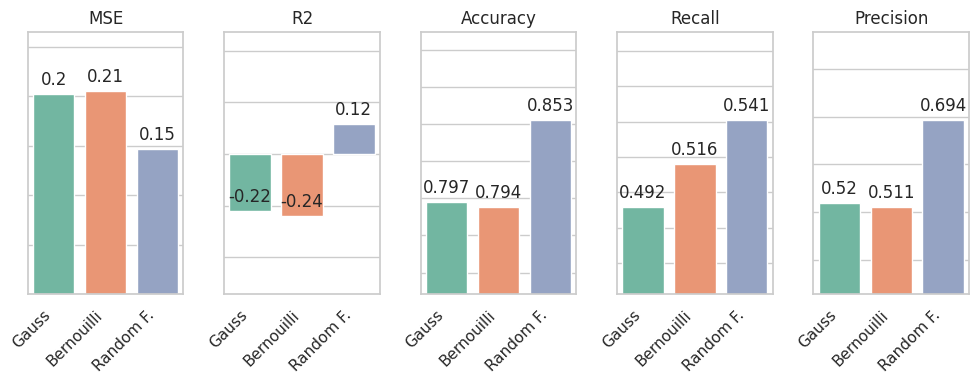

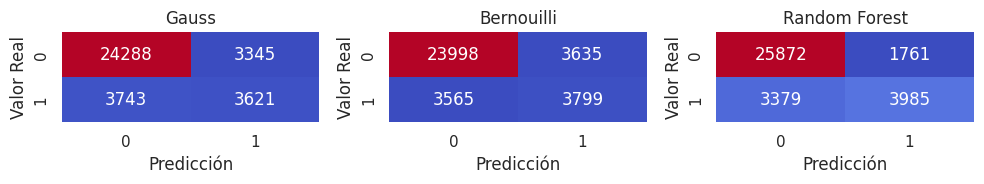

In [59]:

Gauss_mse = mean_squared_error(y_test, y_pred_Gauss)
Bern_mse= mean_squared_error(y_test, y_pred_Bern)

Gauss_r2=r2_score(y_test, y_pred_Gauss)
Bern_r2=r2_score(y_test, y_pred_Bern)

Gauss_acc=accuracy_score(y_test, y_pred_Gauss)
Bern_acc=accuracy_score(y_test, y_pred_Bern)

Gauss_rec=recall_score(y_test, y_pred_Gauss)
Bern_rec=recall_score(y_test, y_pred_Bern)

Gauss_prec=precision_score(y_test, y_pred_Gauss)
Bern_prec=precision_score(y_test, y_pred_Bern)

Gauss_conf= confusion_matrix(y_test, y_pred_Gauss)
Bern_conf= confusion_matrix(y_test, y_pred_Bern)

valoresMSE_=[Gauss_mse,Bern_mse,MSE_RF]
valoresR2_=[Gauss_r2,Bern_r2,R2_RF]
valoresAcc_=[Gauss_acc,Bern_acc,model_acc_RF]
valoresRec_=[Gauss_rec,Bern_rec,rec_RF]
valoresPrec_=[Gauss_prec,Bern_prec,prec_RF]

nombs=['Gauss','Bernouilli','Random F.']


fig, axis= plt.subplots(1,5,figsize=(10,4))

#FILA 1
## 1º GRÁFICO

ax1=sns.barplot(x=nombs,y=valoresMSE_,hue=nombs,ax=axis[0],palette="Set2")
lim0=0
lim1=max(valoresMSE_)+(max(valoresMSE_)-min(valoresMSE_))
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')
axis[0].set_yticklabels([])
axis[0].set_ylim(lim0,lim1)
axis[0].set_title("MSE")

## 2º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresR2_,hue=nombs,ax=axis[1],palette="Set2")
lim0=min(valoresR2_)-(max(valoresR2_)-min(valoresR2_))+0.05
lim1=max(valoresR2_)+(max(valoresR2_)-min(valoresR2_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45, ha='right')
axis[1].set_yticklabels([])
axis[1].set_ylim(lim0,lim1)
axis[1].set_title("R2")

## 3º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresAcc_,hue=nombs,ax=axis[2],palette="Set2")
lim0=min(valoresAcc_)-(max(valoresAcc_)-min(valoresAcc_))
lim1=max(valoresAcc_)+(max(valoresAcc_)-min(valoresAcc_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45, ha='right')
axis[2].set_yticklabels([])
axis[2].set_ylim(lim0,lim1)
axis[2].set_title("Accuracy")

## 4º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresRec_,hue=nombs,ax=axis[3],palette="Set2")
lim0=min(valoresRec_)-(max(valoresRec_)-min(valoresRec_))
lim1=max(valoresRec_)+(max(valoresRec_)-min(valoresRec_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[3].set_xticklabels(axis[3].get_xticklabels(), rotation=45, ha='right')
axis[3].set_yticklabels([])
axis[3].set_ylim(lim0,lim1)
axis[3].set_title("Recall")

## 4º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresPrec_,hue=nombs,ax=axis[4],palette="Set2",)
lim0=min(valoresPrec_)-(max(valoresPrec_)-min(valoresPrec_))
lim1=max(valoresPrec_)+(max(valoresPrec_)-min(valoresPrec_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[4].set_xticklabels(axis[4].get_xticklabels(), rotation=45, ha='right')
axis[4].set_yticklabels([])
axis[4].set_ylim(lim0,lim1)
axis[4].set_title("Precision")


plt.tight_layout()
plt.show()

#FILA 2
fig, axis= plt.subplots(1,3,figsize=(10,2))
## 1º GRÁFICO

sns.heatmap(Gauss_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[0].set_xlabel('Predicción')
axis[0].set_ylabel('Valor Real')
axis[0].set_title('Gauss')

sns.heatmap(Bern_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1].set_xlabel('Predicción')
axis[1].set_ylabel('Valor Real')
axis[1].set_title('Bernouilli')

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[2],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[2].set_xlabel('Predicción')
axis[2].set_ylabel('Valor Real')
axis[2].set_title('Random Forest')

plt.tight_layout()
plt.show()

Como podemos ver, los modelos de Gauss y Bernouilli no mejoran ninguna de las métricas con respecto a la matriz de confusión. Seguimos teniendo que el Random Forest es el mejor modelo hasta ahora.


**DECISION TREE**

In [60]:
model_DT = DecisionTreeClassifier(random_state = 42)
model_DT.fit(X_train_norm, y_train)
y_pred_DT=model_DT.predict(X_test_norm)

Métricas de Decision tree, comparativa con el modelo seleccionado anteriormente: Random Forest

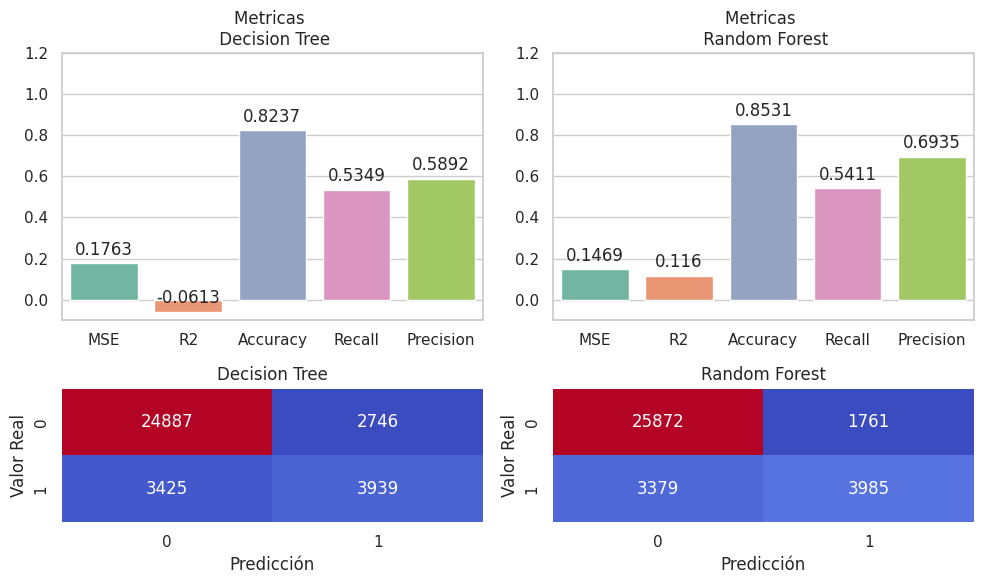

In [61]:

MSE_DT= mean_squared_error(y_test, y_pred_DT)
R2_DT=r2_score(y_test, y_pred_DT)
model_acc_DT=accuracy_score(y_test, y_pred_DT)
rec_DT=recall_score(y_test, y_pred_DT)
prec_DT=precision_score(y_test, y_pred_DT)

DT_conf=confusion_matrix(y_test, y_pred_DT)

valores_DT=[MSE_DT,R2_DT,model_acc_DT,rec_DT,prec_DT]
valores_RF=[MSE_RF,R2_RF,model_acc_RF,rec_RF,prec_RF]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_DT,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Decision Tree")

sns.heatmap(DT_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Decision Tree')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()


Observamos que el modelo de arbol de decisión no mejora ninguna de las métricas con respecto a la matriz de confusión ni el R2. Seguimos teniendo que el Random Forest es el mejor modelo hasta ahora.


**K-NEIGHBORS**

In [62]:
model_KN = KNeighborsClassifier()
model_KN.fit(X_train_norm, y_train)
y_pred_KN=model_KN.predict(X_test_norm)

Métricas de K-Neighbors, comparativa con el modelo seleccionado anteriormente: Random Forest

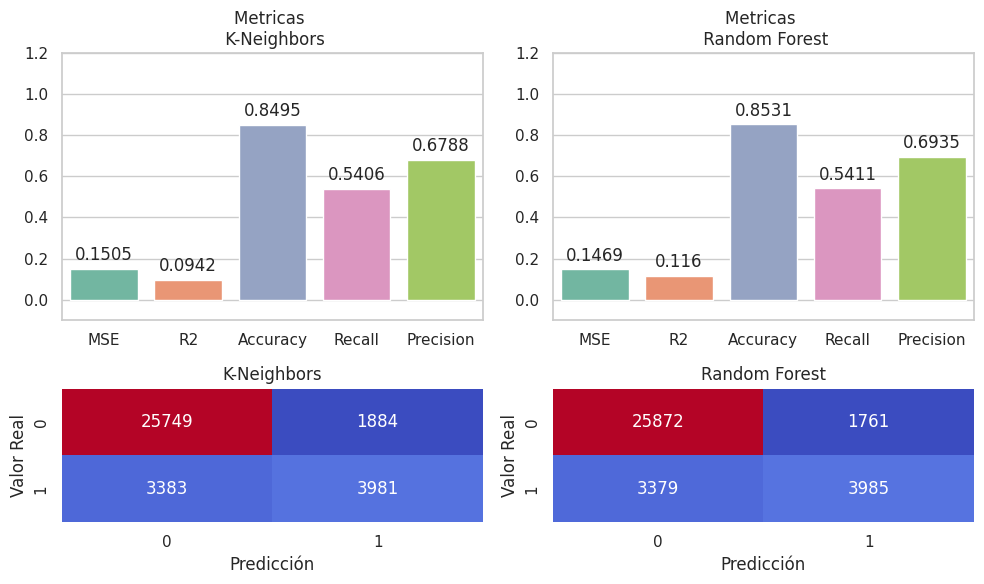

In [63]:

MSE_KN= mean_squared_error(y_test, y_pred_KN)
R2_KN=r2_score(y_test, y_pred_KN)
model_acc_KN=accuracy_score(y_test, y_pred_KN)
rec_KN=recall_score(y_test, y_pred_KN)
prec_KN=precision_score(y_test, y_pred_KN)

KN_conf=confusion_matrix(y_test, y_pred_KN)

valores_KN=[MSE_KN,R2_KN,model_acc_KN,rec_KN,prec_KN]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_KN,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n K-Neighbors")

sns.heatmap(KN_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('K-Neighbors')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()

Observamos que el modelo de K-vecinos no mejora ninguna de las métricas con respecto a la matriz de confusión ni el R2. Seguimos teniendo que el Random Forest es el mejor modelo hasta ahora.


**BOOSTING**

In [64]:
model_Boo = XGBClassifier()
model_Boo.fit(X_train_norm, y_train)
y_pred_Boo=model_Boo.predict(X_test_norm)

Métricas de Boosting, comparativa con el modelo seleccionado anteriormente: Random Forest

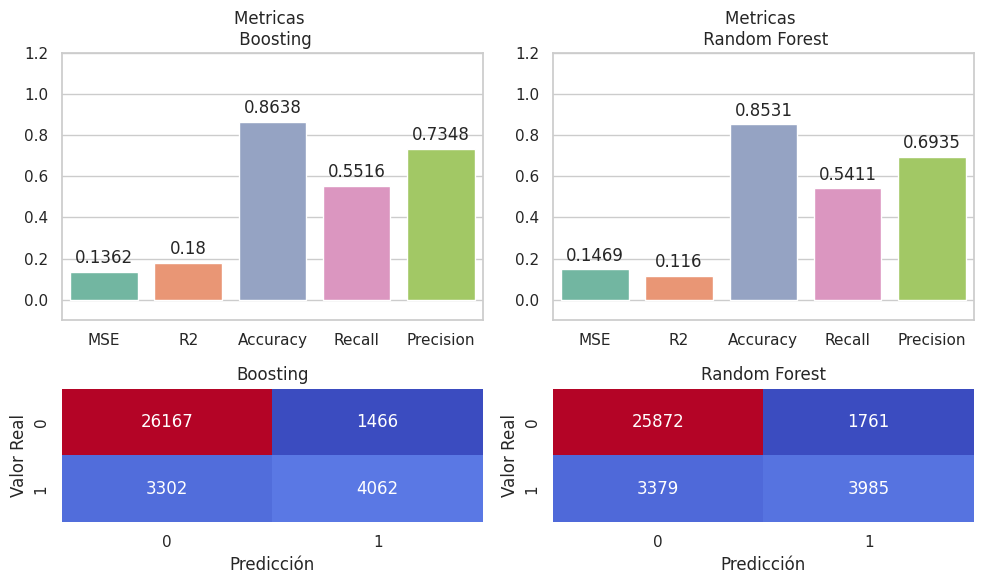

In [65]:

MSE_Boo= mean_squared_error(y_test, y_pred_Boo)
R2_Boo=r2_score(y_test, y_pred_Boo)
model_acc_Boo=accuracy_score(y_test, y_pred_Boo)
rec_Boo=recall_score(y_test, y_pred_Boo)
prec_Boo=precision_score(y_test, y_pred_Boo)

KN_conf=confusion_matrix(y_test, y_pred_Boo)

valores_Boo=[MSE_Boo,R2_Boo,model_acc_Boo,rec_Boo,prec_Boo]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_Boo,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Boosting")

sns.heatmap(KN_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Boosting')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()

En este caso, vemos que el modelo de boosting mejora las métricas del Random Forest tanto relativas a la matriz de confusión como el ajuste con R2. 

Por tanto, nos quedamos con el **modelo Boosting** para realizar nuestro modelo.

Ahora, vamos a ver si podemos mejorar los resultados obtenidos, balanceando la muestra. A continuación vemos una comparativa de los resultados de las métricas según los balanceos tomados: 

Clase 1/0 (Abandono/No abandono)

* Original: 21%/79%
* 50/50
* 35/65
* 30/70

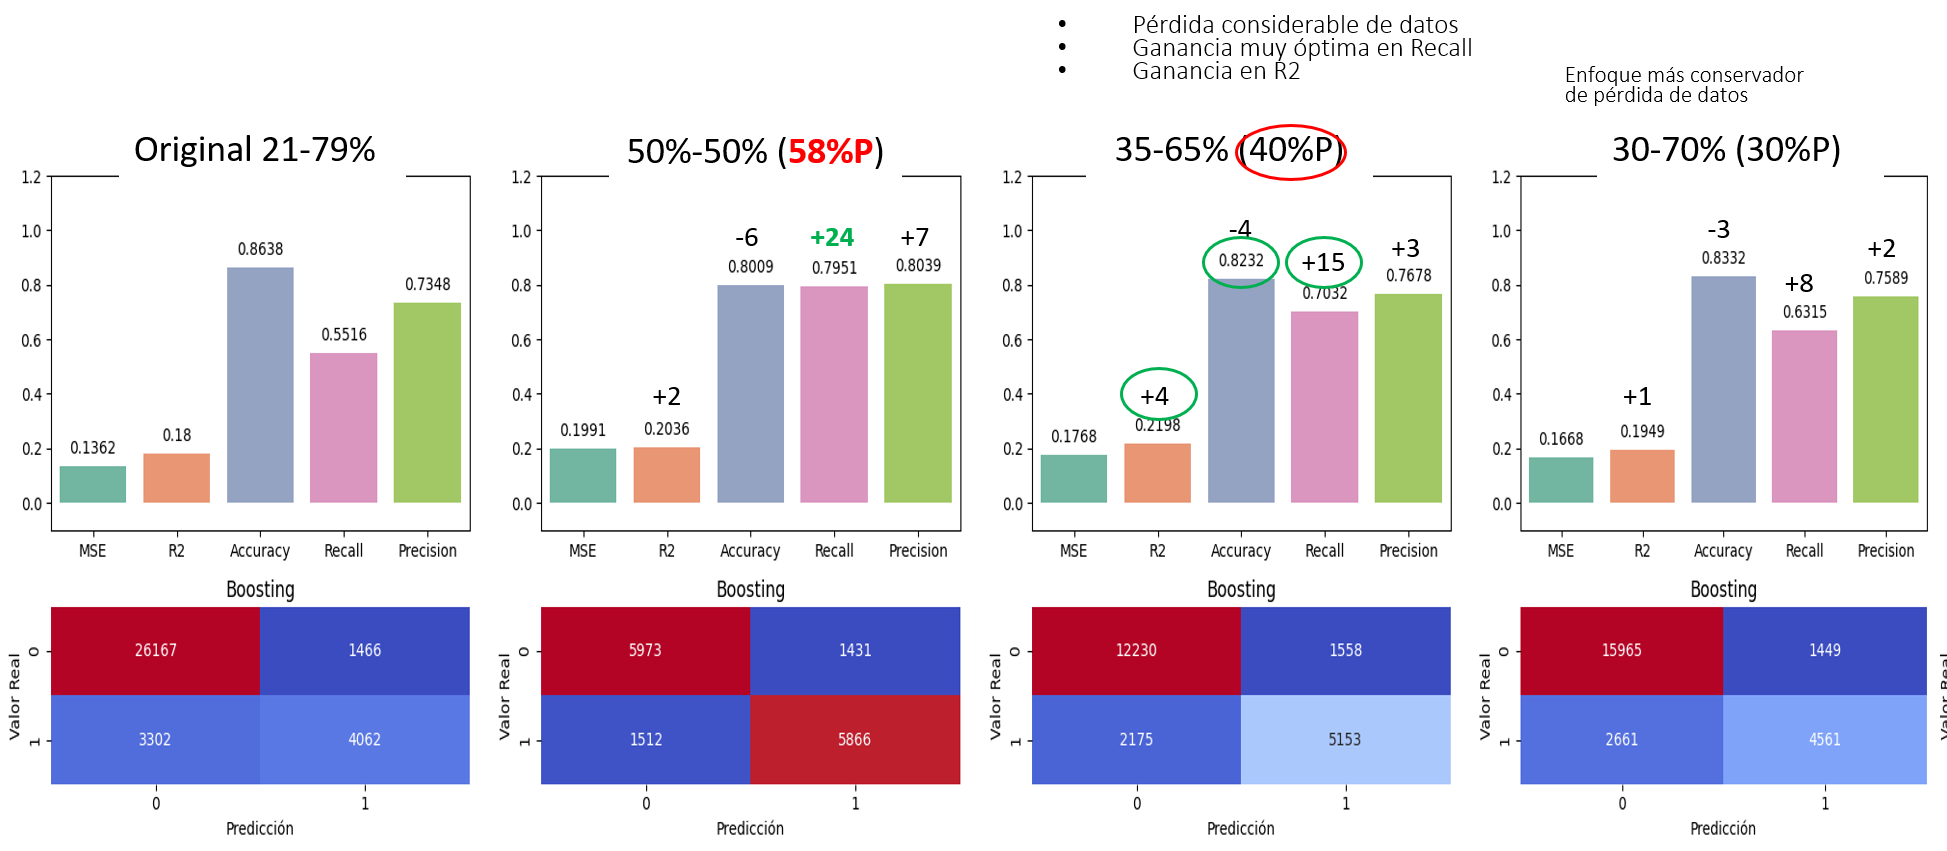

In [67]:
from IPython.display import display
from PIL import Image
import io

#ruta_imagen = 'nombre_de_la_imagen.jpg'  # Reemplaza 'nombre_de_la_imagen.jpg' con la ruta de tu imagen

# Abre la imagen y la muestra en el notebook
imagen = Image.open("/workspaces/Isa-Project/data/Comparativa balanceos.png")
display(imagen)

Nos vamos a quedar con el **balanceo 35/65**, ya que guarda una buena relación de las métricas: el mejor R2, un accuracy razonable del 82,32% y un recall bastante bueno del 70,32% y mucho mejor que el original de 55%. Además, la pérdida de datos es considerable (40%) pero asumimos la pérdida de datos por la ganancia en recall.

Realizamos el ajuste y guardamos el modelo:

In [77]:
# Muestra del 35% de la clase 0 y del 65% de la clase 1

total=len(data_clean['Exited'])
tot_1=len(data_clean[data_clean['Exited'] == 1])
frac_0=0.65
tot_0=int(round(tot_1/(1-frac_0)-tot_1,0))

sample_class_0 = data_clean[data_clean['Exited'] == 0].sample(n=tot_0, random_state=42)
sample_class_1 = data_clean[data_clean['Exited'] == 1]

# Combinamos las muestras para obtener el conjunto de datos balanceado
balanced_data = pd.concat([sample_class_0, sample_class_1])

# Verifica el balance resultante
print(balanced_data['Exited'].value_counts())
print(f"Perdida de datos: {len(data_clean['Exited'])-len(balanced_data['Exited'])}  -- {round((1-len(balanced_data['Exited'])/len(data_clean['Exited']))*100,2)}% ")

Exited
0    68627
1    36953
Name: count, dtype: int64
Perdida de datos: 69405  -- 39.66% 


In [78]:
y=balanced_data["Exited"]
X=balanced_data[vars_mod]

#Separamos la muestra de entrenamiento y test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


#Normalizamos los datos
scaler = StandardScaler()
scaler.fit(X_train)

cols=X.columns
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)


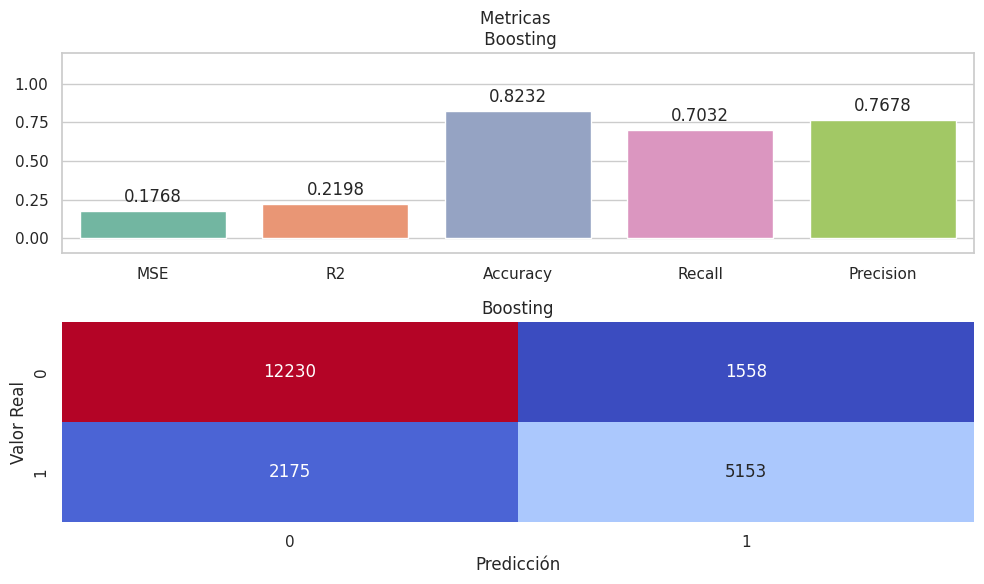

In [79]:
#Entrenamiento de modelo
model_Boo = XGBClassifier()
model_Boo.fit(X_train_norm, y_train)
y_pred_Boo=model_Boo.predict(X_test_norm)

#Cálculo de métricas

MSE_Boo= mean_squared_error(y_test, y_pred_Boo)
R2_Boo=r2_score(y_test, y_pred_Boo)
model_acc_Boo=accuracy_score(y_test, y_pred_Boo)
rec_Boo=recall_score(y_test, y_pred_Boo)
prec_Boo=precision_score(y_test, y_pred_Boo)

Boo_conf=confusion_matrix(y_test, y_pred_Boo)

valores_Boo=[MSE_Boo,R2_Boo,model_acc_Boo,rec_Boo,prec_Boo]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,1,figsize=(10,6))

ax1=sns.barplot(x=nombs,y=valores_Boo,hue=nombs,ax=axis[0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0].set_ylim(lim0,lim1)
axis[0].set_title("Metricas \n Boosting")

sns.heatmap(Boo_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1].set_xlabel('Predicción')
axis[1].set_ylabel('Valor Real')
axis[1].set_title('Boosting')


plt.tight_layout()
plt.show()

Guardamos el modelo

In [ ]:
dump(model_Boo, open("Boosting_65.sav", "wb"))